In [1]:
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
from os import listdir,chdir
import cv2
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.svm import LinearSVC
import time
from scipy.ndimage.measurements import label
from collections import deque
import pickle

C:\Users\akshatha_holla\AppData\Local\Continuum\Miniconda3\envs\carnd-term1\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#load_training_data()

In [2]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

In [ ]:
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [5]:
# print(len(color_hist(sample_car,16)))

In [4]:
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

In [7]:
# len(bin_spatial(sample_car,(16,16)))

In [5]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [9]:
# len(get_hog_features(sample_car[:,:,2], orient, pix_per_cell, cell_per_block, 
#                         vis=False, feature_vec=True))

In [6]:
def extract_features(imgs, color_space='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256),spatial_feat=True, 
                        hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    

In [7]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9 # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16,16) # Spatial binning dimensions
hist_bins = 8    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] 

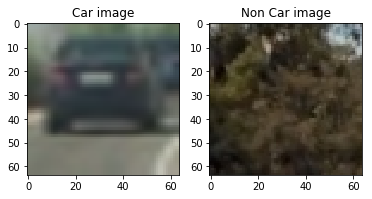

In [8]:

cars=glob.glob('vehicles/*/*.png')
not_cars=glob.glob('non-vehicles/*/*.png')
#print(len(not_cars))
sample_car=mpimg.imread(cars[1])
sample_non_car=mpimg.imread(not_cars[2])
plt.subplot(121)
plt.title("Car image")
plt.imshow(sample_car)
plt.subplot(122)
plt.title("Non Car image")
plt.imshow(sample_non_car)
        
        



   
   

C:\Users\akshatha_holla\AppData\Local\Continuum\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


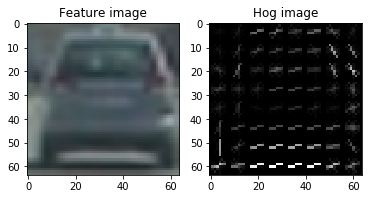

In [9]:
 # Create an array stack of feature vectors
 

feature_image = mpimg.imread(cars[3])
#feature_image = cv2.cvtColor(feature_image, cv2.COLOR_RGB2YCrCb)
features ,hog_image = get_hog_features(feature_image[:,:,2],orient, pix_per_cell, cell_per_block,vis=True, feature_vec=True)

plt.subplot(121)
plt.title("Feature image")
plt.imshow(feature_image)
plt.subplot(122)
plt.title("Hog image")
plt.imshow(hog_image, cmap='gray')
# Plot an example of raw and scaled features

In [10]:
training_sample_size=5000
sub_cars=cars[:]
sub_not_cars=not_cars[:]
car_features = extract_features(sub_cars, color_space=color_space, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel,spatial_size=spatial_size,
                        hist_bins=hist_bins, hist_range=(0, 256),spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(sub_not_cars, color_space=color_space, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel,spatial_size=spatial_size,
                        hist_bins=hist_bins, hist_range=(0, 256),spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
print(len(car_features))
print(len(notcar_features))

C:\Users\akshatha_holla\AppData\Local\Continuum\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


8792
8968


In [11]:
print(car_features[0])
print(len(notcar_features[0]))
X = np.vstack((car_features, notcar_features)).astype(np.float64)
y= np.hstack((np.ones(len(car_features)),np.zeros(len(notcar_features))))

rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)


[0.63954514 0.61673534 0.56450891 ... 0.         0.00567118 0.01498838]
6084


In [16]:
print(len(X[0]))

6084


In [17]:
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

21.21 Seconds to train SVC...
Test Accuracy of SVC =  0.9848
My SVC predicts:  [1. 0. 1. 0. 0. 0. 1. 0. 0. 0.]
For these 10 labels:  [1. 0. 1. 0. 0. 0. 1. 0. 0. 0.]
0.002 Seconds to predict 10 labels with SVC


In [32]:
classifier_data = {'svc': svc, 'X_scaler': X_scaler, 'color_space': color_space, 'orient': orient,
                       'pix_per_cell': pix_per_cell, 'cell_per_block': cell_per_block, 'hog_channel': hog_channel,
                       'spatial_size': spatial_size, 'hist_bins': hist_bins, 'spatial_feat': spatial_feat,
                       'hist_feat': hist_feat, 'hog_feat': hog_feat, 'y_start_stop': y_start_stop}

# Dump the dictionary to a pickle file for future use
#pickle.dump(classifier_data,open('classifier_info_threshold1.p', "wb"))

In [12]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


In [13]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [32]:
def find_cars(img, ystart, ystop, scales, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    box_list=[]
    ctrans_tosearch_img = convert_color(img_tosearch, conv='RGB2YCrCb')
    for scale in scales:
        if scale != 1:
            imshape = ctrans_tosearch_img.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch_img, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        else:
            ctrans_tosearch =ctrans_tosearch_img
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    
        # Define blocks and steps as above
        nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
        nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
        nfeat_per_block = orient*cell_per_block**2
        
        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
        cells_per_step = 2  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
        
        # Compute individual channel HOG features for the entire image
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
        
        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
    
                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
              
                # Get color features
                spatial_features = bin_spatial(subimg, size=spatial_size)
                hist_features = color_hist(subimg, nbins=hist_bins)
    
                # Scale features and make a prediction
                test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
                #test_features = X_scaler.transform(np.hstack((hog_features, None,None)).reshape(1, -1))    
                test_prediction = svc.predict(test_features)
                
                if test_prediction == 1:
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    box = (xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)
                    box_list.append(box)
    # Add heat to each box in box list
    heat = add_heat(heat,box_list)
    #heat_history.append(heat)
    #heat=np.array(heat_history).sum(axis=0)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(draw_img, labels)
    #draw_img =heatmap
    return draw_img
    


In [15]:


def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [16]:
def find_cars_with_heatmap(img, ystart, ystop, scales, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, heat_history,threshold):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    box_list=[]
    ctrans_tosearch_img = convert_color(img_tosearch, conv='RGB2YCrCb')
    for scale in scales:
        if scale != 1:
            imshape = ctrans_tosearch_img.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch_img, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        else:
            ctrans_tosearch =ctrans_tosearch_img
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    
        # Define blocks and steps as above
        nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
        nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
        nfeat_per_block = orient*cell_per_block**2
        
        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
        cells_per_step = 2  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
        
        # Compute individual channel HOG features for the entire image
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
        
        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
    
                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
              
                # Get color features
                spatial_features = bin_spatial(subimg, size=spatial_size)
                hist_features = color_hist(subimg, nbins=hist_bins)
    
                # Scale features and make a prediction
                test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
                #test_features = X_scaler.transform(np.hstack((hog_features, None,None)).reshape(1, -1))    
                test_prediction = svc.predict(test_features)
                
                if test_prediction == 1:
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    box = (xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)
                    box_list.append(box)
    # Add heat to each box in box list
    heat = add_heat(heat,box_list)
    heat_history.append(heat)
    heat=np.array(heat_history).sum(axis=0)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,threshold)
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(draw_img, labels)

    return draw_img
    


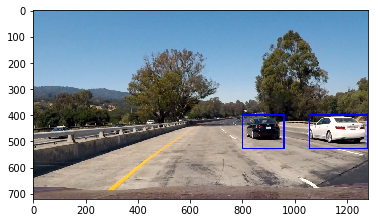

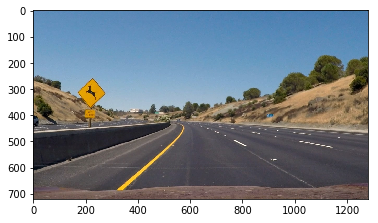

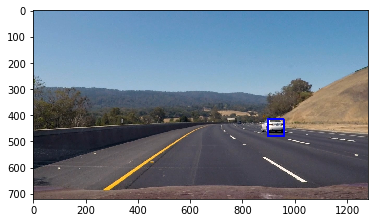

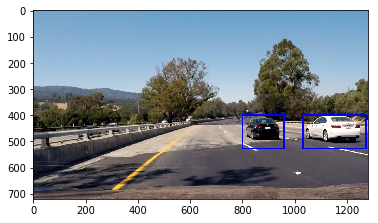

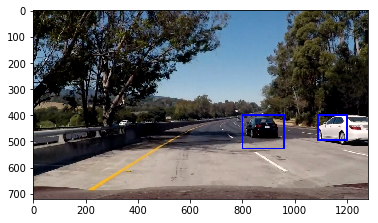

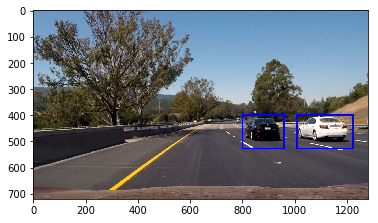

In [34]:
ystart = 400
ystop = 656
scales = [1.0, 1.5, 2.0, 2.5]
heatmap_images_path=("./output_images/heatmap_output/")
classifier_images_path=("./output_images/classifier_output/")
final_images_path=("./output_images/final_output/")
test_images=glob.glob("./test_images/*.jpg")
for image in test_images:
    img=mpimg.imread(image)
    heat_history = deque(maxlen=8)
    threshold=1
    out_img = find_cars_with_heatmap(img, ystart, ystop, scales, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,
                                     heat_history, threshold)
    plt.imshow(out_img)
    #mpimg.imsave(final_images_path+image.split("\\")[-1], out_img)
    plt.show()

In [18]:
def pipeline(img):
    ystart = 400
    ystop = 656
    scales = [1.0, 1.5, 2.0, 2.5]
    heat_history = deque(maxlen=8)
    threshold=1
    out_img = find_cars_with_heatmap(img, ystart, ystop, scales, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,
                                     heat_history, threshold)
    return out_img

In [19]:
from moviepy.editor import VideoFileClip
vid_output = 'final_video_output_final.mp4'

# The file referenced in clip1 is the original video before anything has been done to it
clip1 = VideoFileClip("project_video.mp4")#.subclip('00:00:40.00','00:00:43.00') 
#clip1 = VideoFileClip("project_video.mp4")

# NOTE: this function expects color images
vid_clip = clip1.fl_image(pipeline)
vid_clip.write_videofile(vid_output, audio=False)

[MoviePy] >>>> Building video final_video_output_final.mp4


[MoviePy] Writing video final_video_output_final.mp4


  0%|                                                                                         | 0/1261 [00:00<?, ?it/s]

  0%|                                                                               | 1/1261 [00:03<1:03:53,  3.04s/it]

  0%|▏                                                                              | 2/1261 [00:05<1:00:12,  2.87s/it]

  0%|▏                                                                                | 3/1261 [00:07<57:06,  2.72s/it]

  0%|▎                                                                                | 4/1261 [00:10<54:38,  2.61s/it]

  0%|▎                                                                                | 5/1261 [00:12<52:58,  2.53s/it]

  0%|▍                                                                                | 6/1261 [00:14<51:47,  2.48s/it]

  1%|▍                                                                                | 7/1261 [00:17<50:53,  2.43s/it]

  1%|▌                                                                                | 8/1261 [00:19<50:21,  2.41s/it]

  1%|▌                                                                                | 9/1261 [00:22<50:09,  2.40s/it]

  1%|▋                                                                               | 10/1261 [00:24<49:52,  2.39s/it]

  1%|▋                                                                               | 11/1261 [00:26<49:01,  2.35s/it]

  1%|▊                                                                               | 12/1261 [00:28<48:55,  2.35s/it]

  1%|▊                                                                               | 13/1261 [00:31<48:19,  2.32s/it]

  1%|▉                                                                               | 14/1261 [00:33<47:50,  2.30s/it]

  1%|▉                                                                               | 15/1261 [00:35<47:29,  2.29s/it]

  1%|█                                                                               | 16/1261 [00:37<47:09,  2.27s/it]

  1%|█                                                                               | 17/1261 [00:40<46:57,  2.26s/it]

  1%|█▏                                                                              | 18/1261 [00:42<47:04,  2.27s/it]

  2%|█▏                                                                              | 19/1261 [00:44<47:07,  2.28s/it]

  2%|█▎                                                                              | 20/1261 [00:47<47:04,  2.28s/it]

  2%|█▎                                                                              | 21/1261 [00:49<46:58,  2.27s/it]

  2%|█▍                                                                              | 22/1261 [00:51<46:59,  2.28s/it]

  2%|█▍                                                                              | 23/1261 [00:53<46:58,  2.28s/it]

  2%|█▌                                                                              | 24/1261 [00:56<46:58,  2.28s/it]

  2%|█▌                                                                              | 25/1261 [00:58<47:04,  2.29s/it]

  2%|█▋                                                                              | 26/1261 [01:00<47:57,  2.33s/it]

  2%|█▋                                                                              | 27/1261 [01:03<47:43,  2.32s/it]

  2%|█▊                                                                              | 28/1261 [01:05<47:25,  2.31s/it]

  2%|█▊                                                                              | 29/1261 [01:07<47:14,  2.30s/it]

  2%|█▉                                                                              | 30/1261 [01:10<47:09,  2.30s/it]

  2%|█▉                                                                              | 31/1261 [01:12<46:52,  2.29s/it]

  3%|██                                                                              | 32/1261 [01:14<46:37,  2.28s/it]

  3%|██                                                                              | 33/1261 [01:16<46:27,  2.27s/it]

  3%|██▏                                                                             | 34/1261 [01:19<46:42,  2.28s/it]

  3%|██▏                                                                             | 35/1261 [01:21<46:43,  2.29s/it]

  3%|██▎                                                                             | 36/1261 [01:23<47:23,  2.32s/it]

  3%|██▎                                                                             | 37/1261 [01:26<47:48,  2.34s/it]

  3%|██▍                                                                             | 38/1261 [01:29<53:17,  2.61s/it]

  3%|██▍                                                                             | 39/1261 [01:33<58:52,  2.89s/it]

  3%|██▍                                                                           | 40/1261 [01:36<1:02:24,  3.07s/it]

  3%|██▌                                                                           | 41/1261 [01:39<1:00:26,  2.97s/it]

  3%|██▋                                                                             | 42/1261 [01:41<56:31,  2.78s/it]

  3%|██▋                                                                             | 43/1261 [01:43<53:33,  2.64s/it]

  3%|██▊                                                                             | 44/1261 [01:46<51:01,  2.52s/it]

  4%|██▊                                                                             | 45/1261 [01:48<49:25,  2.44s/it]

  4%|██▉                                                                             | 46/1261 [01:50<48:27,  2.39s/it]

  4%|██▉                                                                             | 47/1261 [01:53<48:00,  2.37s/it]

  4%|███                                                                             | 48/1261 [01:55<47:21,  2.34s/it]

  4%|███                                                                             | 49/1261 [01:57<46:50,  2.32s/it]

  4%|███▏                                                                            | 50/1261 [01:59<46:21,  2.30s/it]

  4%|███▏                                                                            | 51/1261 [02:02<46:54,  2.33s/it]

  4%|███▎                                                                            | 52/1261 [02:04<46:29,  2.31s/it]

  4%|███▎                                                                            | 53/1261 [02:06<46:09,  2.29s/it]

  4%|███▍                                                                            | 54/1261 [02:08<45:58,  2.29s/it]

  4%|███▍                                                                            | 55/1261 [02:11<45:50,  2.28s/it]

  4%|███▌                                                                            | 56/1261 [02:13<45:48,  2.28s/it]

  5%|███▌                                                                            | 57/1261 [02:15<45:34,  2.27s/it]

  5%|███▋                                                                            | 58/1261 [02:18<46:11,  2.30s/it]

  5%|███▋                                                                            | 59/1261 [02:20<45:56,  2.29s/it]

  5%|███▊                                                                            | 60/1261 [02:22<46:28,  2.32s/it]

  5%|███▊                                                                            | 61/1261 [02:25<46:56,  2.35s/it]

  5%|███▉                                                                            | 62/1261 [02:27<46:53,  2.35s/it]

  5%|███▉                                                                            | 63/1261 [02:29<46:20,  2.32s/it]

  5%|████                                                                            | 64/1261 [02:32<46:02,  2.31s/it]

  5%|████                                                                            | 65/1261 [02:34<45:32,  2.28s/it]

  5%|████▏                                                                           | 66/1261 [02:36<45:36,  2.29s/it]

  5%|████▎                                                                           | 67/1261 [02:38<45:22,  2.28s/it]

  5%|████▎                                                                           | 68/1261 [02:41<45:32,  2.29s/it]

  5%|████▍                                                                           | 69/1261 [02:43<45:21,  2.28s/it]

  6%|████▍                                                                           | 70/1261 [02:45<45:19,  2.28s/it]

  6%|████▌                                                                           | 71/1261 [02:48<45:13,  2.28s/it]

  6%|████▌                                                                           | 72/1261 [02:50<45:03,  2.27s/it]

  6%|████▋                                                                           | 73/1261 [02:52<44:58,  2.27s/it]

  6%|████▋                                                                           | 74/1261 [02:54<44:51,  2.27s/it]

  6%|████▊                                                                           | 75/1261 [02:57<44:44,  2.26s/it]

  6%|████▊                                                                           | 76/1261 [02:59<44:38,  2.26s/it]

  6%|████▉                                                                           | 77/1261 [03:01<45:54,  2.33s/it]

  6%|████▉                                                                           | 78/1261 [03:04<46:31,  2.36s/it]

  6%|█████                                                                           | 79/1261 [03:06<46:04,  2.34s/it]

  6%|█████                                                                           | 80/1261 [03:08<45:55,  2.33s/it]

  6%|█████▏                                                                          | 81/1261 [03:11<45:27,  2.31s/it]

  7%|█████▏                                                                          | 82/1261 [03:13<45:31,  2.32s/it]

  7%|█████▎                                                                          | 83/1261 [03:15<45:17,  2.31s/it]

  7%|█████▎                                                                          | 84/1261 [03:17<45:00,  2.29s/it]

  7%|█████▍                                                                          | 85/1261 [03:20<44:43,  2.28s/it]

  7%|█████▍                                                                          | 86/1261 [03:22<44:36,  2.28s/it]

  7%|█████▌                                                                          | 87/1261 [03:24<44:26,  2.27s/it]

  7%|█████▌                                                                          | 88/1261 [03:27<44:47,  2.29s/it]

  7%|█████▋                                                                          | 89/1261 [03:29<45:02,  2.31s/it]

  7%|█████▋                                                                          | 90/1261 [03:31<44:50,  2.30s/it]

  7%|█████▊                                                                          | 91/1261 [03:33<44:21,  2.28s/it]

  7%|█████▊                                                                          | 92/1261 [03:36<44:23,  2.28s/it]

  7%|█████▉                                                                          | 93/1261 [03:38<44:40,  2.29s/it]

  7%|█████▉                                                                          | 94/1261 [03:40<44:23,  2.28s/it]

  8%|██████                                                                          | 95/1261 [03:43<44:31,  2.29s/it]

  8%|██████                                                                          | 96/1261 [03:45<44:41,  2.30s/it]

  8%|██████▏                                                                         | 97/1261 [03:47<44:35,  2.30s/it]

  8%|██████▏                                                                         | 98/1261 [03:50<44:23,  2.29s/it]

  8%|██████▎                                                                         | 99/1261 [03:52<44:10,  2.28s/it]

  8%|██████▎                                                                        | 100/1261 [03:54<44:03,  2.28s/it]

  8%|██████▎                                                                        | 101/1261 [03:56<43:53,  2.27s/it]

  8%|██████▍                                                                        | 102/1261 [03:59<44:24,  2.30s/it]

  8%|██████▍                                                                        | 103/1261 [04:01<44:02,  2.28s/it]

  8%|██████▌                                                                        | 104/1261 [04:03<44:42,  2.32s/it]

  8%|██████▌                                                                        | 105/1261 [04:06<45:06,  2.34s/it]

  8%|██████▋                                                                        | 106/1261 [04:08<44:38,  2.32s/it]

  8%|██████▋                                                                        | 107/1261 [04:10<44:28,  2.31s/it]

  9%|██████▊                                                                        | 108/1261 [04:13<44:10,  2.30s/it]

  9%|██████▊                                                                        | 109/1261 [04:15<43:55,  2.29s/it]

  9%|██████▉                                                                        | 110/1261 [04:17<43:34,  2.27s/it]

  9%|██████▉                                                                        | 111/1261 [04:19<43:44,  2.28s/it]

  9%|███████                                                                        | 112/1261 [04:22<44:17,  2.31s/it]

  9%|███████                                                                        | 113/1261 [04:24<44:10,  2.31s/it]

  9%|███████▏                                                                       | 114/1261 [04:26<44:14,  2.31s/it]

  9%|███████▏                                                                       | 115/1261 [04:29<44:51,  2.35s/it]

  9%|███████▎                                                                       | 116/1261 [04:31<44:29,  2.33s/it]

  9%|███████▎                                                                       | 117/1261 [04:33<44:12,  2.32s/it]

  9%|███████▍                                                                       | 118/1261 [04:36<44:48,  2.35s/it]

  9%|███████▍                                                                       | 119/1261 [04:38<45:07,  2.37s/it]

 10%|███████▌                                                                       | 120/1261 [04:40<44:24,  2.34s/it]

 10%|███████▌                                                                       | 121/1261 [04:43<44:02,  2.32s/it]

 10%|███████▋                                                                       | 122/1261 [04:45<43:38,  2.30s/it]

 10%|███████▋                                                                       | 123/1261 [04:47<43:20,  2.29s/it]

 10%|███████▊                                                                       | 124/1261 [04:50<43:13,  2.28s/it]

 10%|███████▊                                                                       | 125/1261 [04:52<43:05,  2.28s/it]

 10%|███████▉                                                                       | 126/1261 [04:54<42:54,  2.27s/it]

 10%|███████▉                                                                       | 127/1261 [04:56<42:46,  2.26s/it]

 10%|████████                                                                       | 128/1261 [04:59<42:44,  2.26s/it]

 10%|████████                                                                       | 129/1261 [05:01<42:43,  2.26s/it]

 10%|████████▏                                                                      | 130/1261 [05:03<43:34,  2.31s/it]

 10%|████████▏                                                                      | 131/1261 [05:06<43:30,  2.31s/it]

 10%|████████▎                                                                      | 132/1261 [05:08<43:08,  2.29s/it]

 11%|████████▎                                                                      | 133/1261 [05:10<42:55,  2.28s/it]

 11%|████████▍                                                                      | 134/1261 [05:13<44:51,  2.39s/it]

 11%|████████▍                                                                      | 135/1261 [05:15<46:07,  2.46s/it]

 11%|████████▌                                                                      | 136/1261 [05:18<46:53,  2.50s/it]

 11%|████████▌                                                                      | 137/1261 [05:21<47:47,  2.55s/it]

 11%|████████▋                                                                      | 138/1261 [05:23<47:02,  2.51s/it]

 11%|████████▋                                                                      | 139/1261 [05:25<46:06,  2.47s/it]

 11%|████████▊                                                                      | 140/1261 [05:28<45:26,  2.43s/it]

 11%|████████▊                                                                      | 141/1261 [05:30<44:57,  2.41s/it]

 11%|████████▉                                                                      | 142/1261 [05:32<44:43,  2.40s/it]

 11%|████████▉                                                                      | 143/1261 [05:35<44:54,  2.41s/it]

 11%|█████████                                                                      | 144/1261 [05:37<44:17,  2.38s/it]

 11%|█████████                                                                      | 145/1261 [05:40<44:01,  2.37s/it]

 12%|█████████▏                                                                     | 146/1261 [05:42<43:29,  2.34s/it]

 12%|█████████▏                                                                     | 147/1261 [05:44<43:38,  2.35s/it]

 12%|█████████▎                                                                     | 148/1261 [05:46<43:09,  2.33s/it]

 12%|█████████▎                                                                     | 149/1261 [05:49<43:11,  2.33s/it]

 12%|█████████▍                                                                     | 150/1261 [05:51<43:09,  2.33s/it]

 12%|█████████▍                                                                     | 151/1261 [05:53<43:16,  2.34s/it]

 12%|█████████▌                                                                     | 152/1261 [05:56<43:43,  2.37s/it]

 12%|█████████▌                                                                     | 153/1261 [05:58<44:31,  2.41s/it]

 12%|█████████▋                                                                     | 154/1261 [06:01<43:38,  2.37s/it]

 12%|█████████▋                                                                     | 155/1261 [06:03<44:17,  2.40s/it]

 12%|█████████▊                                                                     | 156/1261 [06:06<44:28,  2.41s/it]

 12%|█████████▊                                                                     | 157/1261 [06:08<44:42,  2.43s/it]

 13%|█████████▉                                                                     | 158/1261 [06:10<43:49,  2.38s/it]

 13%|█████████▉                                                                     | 159/1261 [06:13<43:48,  2.39s/it]

 13%|██████████                                                                     | 160/1261 [06:15<43:27,  2.37s/it]

 13%|██████████                                                                     | 161/1261 [06:17<42:47,  2.33s/it]

 13%|██████████▏                                                                    | 162/1261 [06:20<42:20,  2.31s/it]

 13%|██████████▏                                                                    | 163/1261 [06:22<42:35,  2.33s/it]

 13%|██████████▎                                                                    | 164/1261 [06:24<43:29,  2.38s/it]

 13%|██████████▎                                                                    | 165/1261 [06:27<42:37,  2.33s/it]

 13%|██████████▍                                                                    | 166/1261 [06:29<43:17,  2.37s/it]

 13%|██████████▍                                                                    | 167/1261 [06:31<42:46,  2.35s/it]

 13%|██████████▌                                                                    | 168/1261 [06:34<42:56,  2.36s/it]

 13%|██████████▌                                                                    | 169/1261 [06:36<42:55,  2.36s/it]

 13%|██████████▋                                                                    | 170/1261 [06:38<42:14,  2.32s/it]

 14%|██████████▋                                                                    | 171/1261 [06:41<41:40,  2.29s/it]

 14%|██████████▊                                                                    | 172/1261 [06:43<41:23,  2.28s/it]

 14%|██████████▊                                                                    | 173/1261 [06:45<41:21,  2.28s/it]

 14%|██████████▉                                                                    | 174/1261 [06:48<41:52,  2.31s/it]

 14%|██████████▉                                                                    | 175/1261 [06:50<41:38,  2.30s/it]

 14%|███████████                                                                    | 176/1261 [06:52<41:56,  2.32s/it]

 14%|███████████                                                                    | 177/1261 [06:55<42:28,  2.35s/it]

 14%|███████████▏                                                                   | 178/1261 [06:57<42:11,  2.34s/it]

 14%|███████████▏                                                                   | 179/1261 [06:59<41:43,  2.31s/it]

 14%|███████████▎                                                                   | 180/1261 [07:01<41:20,  2.29s/it]

 14%|███████████▎                                                                   | 181/1261 [07:04<41:44,  2.32s/it]

 14%|███████████▍                                                                   | 182/1261 [07:06<41:19,  2.30s/it]

 15%|███████████▍                                                                   | 183/1261 [07:08<42:02,  2.34s/it]

 15%|███████████▌                                                                   | 184/1261 [07:11<41:31,  2.31s/it]

 15%|███████████▌                                                                   | 185/1261 [07:13<41:19,  2.30s/it]

 15%|███████████▋                                                                   | 186/1261 [07:15<41:13,  2.30s/it]

 15%|███████████▋                                                                   | 187/1261 [07:18<40:56,  2.29s/it]

 15%|███████████▊                                                                   | 188/1261 [07:20<40:51,  2.28s/it]

 15%|███████████▊                                                                   | 189/1261 [07:22<40:40,  2.28s/it]

 15%|███████████▉                                                                   | 190/1261 [07:24<40:38,  2.28s/it]

 15%|███████████▉                                                                   | 191/1261 [07:27<40:37,  2.28s/it]

 15%|████████████                                                                   | 192/1261 [07:29<40:32,  2.28s/it]

 15%|████████████                                                                   | 193/1261 [07:31<40:31,  2.28s/it]

 15%|████████████▏                                                                  | 194/1261 [07:33<40:26,  2.27s/it]

 15%|████████████▏                                                                  | 195/1261 [07:36<40:14,  2.27s/it]

 16%|████████████▎                                                                  | 196/1261 [07:38<39:58,  2.25s/it]

 16%|████████████▎                                                                  | 197/1261 [07:40<39:57,  2.25s/it]

 16%|████████████▍                                                                  | 198/1261 [07:42<40:01,  2.26s/it]

 16%|████████████▍                                                                  | 199/1261 [07:45<39:59,  2.26s/it]

 16%|████████████▌                                                                  | 200/1261 [07:47<40:14,  2.28s/it]

 16%|████████████▌                                                                  | 201/1261 [07:49<40:03,  2.27s/it]

 16%|████████████▋                                                                  | 202/1261 [07:52<40:00,  2.27s/it]

 16%|████████████▋                                                                  | 203/1261 [07:54<39:59,  2.27s/it]

 16%|████████████▊                                                                  | 204/1261 [07:56<39:58,  2.27s/it]

 16%|████████████▊                                                                  | 205/1261 [07:58<39:57,  2.27s/it]

 16%|████████████▉                                                                  | 206/1261 [08:01<39:53,  2.27s/it]

 16%|████████████▉                                                                  | 207/1261 [08:03<39:53,  2.27s/it]

 16%|█████████████                                                                  | 208/1261 [08:05<40:24,  2.30s/it]

 17%|█████████████                                                                  | 209/1261 [08:08<40:04,  2.29s/it]

 17%|█████████████▏                                                                 | 210/1261 [08:10<39:46,  2.27s/it]

 17%|█████████████▏                                                                 | 211/1261 [08:12<39:30,  2.26s/it]

 17%|█████████████▎                                                                 | 212/1261 [08:14<39:27,  2.26s/it]

 17%|█████████████▎                                                                 | 213/1261 [08:17<39:38,  2.27s/it]

 17%|█████████████▍                                                                 | 214/1261 [08:19<39:36,  2.27s/it]

 17%|█████████████▍                                                                 | 215/1261 [08:21<39:31,  2.27s/it]

 17%|█████████████▌                                                                 | 216/1261 [08:23<39:29,  2.27s/it]

 17%|█████████████▌                                                                 | 217/1261 [08:26<39:28,  2.27s/it]

 17%|█████████████▋                                                                 | 218/1261 [08:28<39:23,  2.27s/it]

 17%|█████████████▋                                                                 | 219/1261 [08:30<39:22,  2.27s/it]

 17%|█████████████▊                                                                 | 220/1261 [08:32<39:30,  2.28s/it]

 18%|█████████████▊                                                                 | 221/1261 [08:35<41:37,  2.40s/it]

 18%|█████████████▉                                                                 | 222/1261 [08:38<41:24,  2.39s/it]

 18%|█████████████▉                                                                 | 223/1261 [08:40<41:38,  2.41s/it]

 18%|██████████████                                                                 | 224/1261 [08:42<41:16,  2.39s/it]

 18%|██████████████                                                                 | 225/1261 [08:45<40:43,  2.36s/it]

 18%|██████████████▏                                                                | 226/1261 [08:47<40:17,  2.34s/it]

 18%|██████████████▏                                                                | 227/1261 [08:49<39:48,  2.31s/it]

 18%|██████████████▎                                                                | 228/1261 [08:51<39:24,  2.29s/it]

 18%|██████████████▎                                                                | 229/1261 [08:54<39:18,  2.29s/it]

 18%|██████████████▍                                                                | 230/1261 [08:56<39:07,  2.28s/it]

 18%|██████████████▍                                                                | 231/1261 [08:58<38:58,  2.27s/it]

 18%|██████████████▌                                                                | 232/1261 [09:00<38:58,  2.27s/it]

 18%|██████████████▌                                                                | 233/1261 [09:03<38:50,  2.27s/it]

 19%|██████████████▋                                                                | 234/1261 [09:05<39:29,  2.31s/it]

 19%|██████████████▋                                                                | 235/1261 [09:07<39:07,  2.29s/it]

 19%|██████████████▊                                                                | 236/1261 [09:10<38:52,  2.28s/it]

 19%|██████████████▊                                                                | 237/1261 [09:12<38:41,  2.27s/it]

 19%|██████████████▉                                                                | 238/1261 [09:14<38:28,  2.26s/it]

 19%|██████████████▉                                                                | 239/1261 [09:16<38:19,  2.25s/it]

 19%|███████████████                                                                | 240/1261 [09:19<38:10,  2.24s/it]

 19%|███████████████                                                                | 241/1261 [09:21<38:08,  2.24s/it]

 19%|███████████████▏                                                               | 242/1261 [09:23<38:00,  2.24s/it]

 19%|███████████████▏                                                               | 243/1261 [09:25<37:55,  2.23s/it]

 19%|███████████████▎                                                               | 244/1261 [09:27<37:50,  2.23s/it]

 19%|███████████████▎                                                               | 245/1261 [09:30<37:48,  2.23s/it]

 20%|███████████████▍                                                               | 246/1261 [09:32<38:00,  2.25s/it]

 20%|███████████████▍                                                               | 247/1261 [09:34<37:55,  2.24s/it]

 20%|███████████████▌                                                               | 248/1261 [09:36<37:46,  2.24s/it]

 20%|███████████████▌                                                               | 249/1261 [09:39<37:43,  2.24s/it]

 20%|███████████████▋                                                               | 250/1261 [09:41<37:48,  2.24s/it]

 20%|███████████████▋                                                               | 251/1261 [09:43<38:07,  2.27s/it]

 20%|███████████████▊                                                               | 252/1261 [09:46<38:31,  2.29s/it]

 20%|███████████████▊                                                               | 253/1261 [09:48<38:35,  2.30s/it]

 20%|███████████████▉                                                               | 254/1261 [09:50<38:10,  2.28s/it]

 20%|███████████████▉                                                               | 255/1261 [09:52<38:30,  2.30s/it]

 20%|████████████████                                                               | 256/1261 [09:55<38:20,  2.29s/it]

 20%|████████████████                                                               | 257/1261 [09:57<38:16,  2.29s/it]

 20%|████████████████▏                                                              | 258/1261 [09:59<38:26,  2.30s/it]

 21%|████████████████▏                                                              | 259/1261 [10:02<38:18,  2.29s/it]

 21%|████████████████▎                                                              | 260/1261 [10:04<38:38,  2.32s/it]

 21%|████████████████▎                                                              | 261/1261 [10:06<39:12,  2.35s/it]

 21%|████████████████▍                                                              | 262/1261 [10:09<38:36,  2.32s/it]

 21%|████████████████▍                                                              | 263/1261 [10:11<38:11,  2.30s/it]

 21%|████████████████▌                                                              | 264/1261 [10:13<38:01,  2.29s/it]

 21%|████████████████▌                                                              | 265/1261 [10:15<37:52,  2.28s/it]

 21%|████████████████▋                                                              | 266/1261 [10:18<37:58,  2.29s/it]

 21%|████████████████▋                                                              | 267/1261 [10:20<37:49,  2.28s/it]

 21%|████████████████▊                                                              | 268/1261 [10:22<37:39,  2.28s/it]

 21%|████████████████▊                                                              | 269/1261 [10:25<37:28,  2.27s/it]

 21%|████████████████▉                                                              | 270/1261 [10:27<37:29,  2.27s/it]

 21%|████████████████▉                                                              | 271/1261 [10:29<37:24,  2.27s/it]

 22%|█████████████████                                                              | 272/1261 [10:31<37:23,  2.27s/it]

 22%|█████████████████                                                              | 273/1261 [10:34<37:57,  2.31s/it]

 22%|█████████████████▏                                                             | 274/1261 [10:36<37:42,  2.29s/it]

 22%|█████████████████▏                                                             | 275/1261 [10:38<37:27,  2.28s/it]

 22%|█████████████████▎                                                             | 276/1261 [10:41<37:23,  2.28s/it]

 22%|█████████████████▎                                                             | 277/1261 [10:43<37:20,  2.28s/it]

 22%|█████████████████▍                                                             | 278/1261 [10:45<37:07,  2.27s/it]

 22%|█████████████████▍                                                             | 279/1261 [10:47<37:13,  2.27s/it]

 22%|█████████████████▌                                                             | 280/1261 [10:50<37:06,  2.27s/it]

 22%|█████████████████▌                                                             | 281/1261 [10:52<37:03,  2.27s/it]

 22%|█████████████████▋                                                             | 282/1261 [10:54<37:02,  2.27s/it]

 22%|█████████████████▋                                                             | 283/1261 [10:56<36:57,  2.27s/it]

 23%|█████████████████▊                                                             | 284/1261 [10:59<36:58,  2.27s/it]

 23%|█████████████████▊                                                             | 285/1261 [11:01<36:56,  2.27s/it]

 23%|█████████████████▉                                                             | 286/1261 [11:03<36:48,  2.27s/it]

 23%|█████████████████▉                                                             | 287/1261 [11:06<37:42,  2.32s/it]

 23%|██████████████████                                                             | 288/1261 [11:08<37:28,  2.31s/it]

 23%|██████████████████                                                             | 289/1261 [11:10<37:17,  2.30s/it]

 23%|██████████████████▏                                                            | 290/1261 [11:12<37:08,  2.29s/it]

 23%|██████████████████▏                                                            | 291/1261 [11:15<36:59,  2.29s/it]

 23%|██████████████████▎                                                            | 292/1261 [11:17<36:50,  2.28s/it]

 23%|██████████████████▎                                                            | 293/1261 [11:19<36:48,  2.28s/it]

 23%|██████████████████▍                                                            | 294/1261 [11:22<36:50,  2.29s/it]

 23%|██████████████████▍                                                            | 295/1261 [11:24<36:41,  2.28s/it]

 23%|██████████████████▌                                                            | 296/1261 [11:26<36:36,  2.28s/it]

 24%|██████████████████▌                                                            | 297/1261 [11:28<36:32,  2.27s/it]

 24%|██████████████████▋                                                            | 298/1261 [11:31<36:31,  2.28s/it]

 24%|██████████████████▋                                                            | 299/1261 [11:33<36:56,  2.30s/it]

 24%|██████████████████▊                                                            | 300/1261 [11:36<38:12,  2.39s/it]

 24%|██████████████████▊                                                            | 301/1261 [11:40<47:47,  2.99s/it]

 24%|██████████████████▉                                                            | 302/1261 [11:44<50:24,  3.15s/it]

 24%|██████████████████▉                                                            | 303/1261 [11:47<51:23,  3.22s/it]

 24%|███████████████████                                                            | 304/1261 [11:50<50:55,  3.19s/it]

 24%|███████████████████                                                            | 305/1261 [11:53<49:24,  3.10s/it]

 24%|███████████████████▏                                                           | 306/1261 [11:56<48:17,  3.03s/it]

 24%|███████████████████▏                                                           | 307/1261 [11:58<44:42,  2.81s/it]

 24%|███████████████████▎                                                           | 308/1261 [12:00<41:57,  2.64s/it]

 25%|███████████████████▎                                                           | 309/1261 [12:03<40:01,  2.52s/it]

 25%|███████████████████▍                                                           | 310/1261 [12:05<38:41,  2.44s/it]

 25%|███████████████████▍                                                           | 311/1261 [12:07<38:32,  2.43s/it]

 25%|███████████████████▌                                                           | 312/1261 [12:10<37:43,  2.39s/it]

 25%|███████████████████▌                                                           | 313/1261 [12:12<37:06,  2.35s/it]

 25%|███████████████████▋                                                           | 314/1261 [12:14<36:55,  2.34s/it]

 25%|███████████████████▋                                                           | 315/1261 [12:16<36:39,  2.33s/it]

 25%|███████████████████▊                                                           | 316/1261 [12:19<36:25,  2.31s/it]

 25%|███████████████████▊                                                           | 317/1261 [12:21<36:08,  2.30s/it]

 25%|███████████████████▉                                                           | 318/1261 [12:23<35:53,  2.28s/it]

 25%|███████████████████▉                                                           | 319/1261 [12:26<36:16,  2.31s/it]

 25%|████████████████████                                                           | 320/1261 [12:28<36:13,  2.31s/it]

 25%|████████████████████                                                           | 321/1261 [12:30<36:00,  2.30s/it]

 26%|████████████████████▏                                                          | 322/1261 [12:32<35:44,  2.28s/it]

 26%|████████████████████▏                                                          | 323/1261 [12:35<35:34,  2.28s/it]

 26%|████████████████████▎                                                          | 324/1261 [12:37<35:27,  2.27s/it]

 26%|████████████████████▎                                                          | 325/1261 [12:39<35:29,  2.28s/it]

 26%|████████████████████▍                                                          | 326/1261 [12:41<35:27,  2.28s/it]

 26%|████████████████████▍                                                          | 327/1261 [12:44<35:36,  2.29s/it]

 26%|████████████████████▌                                                          | 328/1261 [12:46<35:27,  2.28s/it]

 26%|████████████████████▌                                                          | 329/1261 [12:48<35:30,  2.29s/it]

 26%|████████████████████▋                                                          | 330/1261 [12:51<35:46,  2.31s/it]

 26%|████████████████████▋                                                          | 331/1261 [12:53<35:55,  2.32s/it]

 26%|████████████████████▊                                                          | 332/1261 [12:55<35:44,  2.31s/it]

 26%|████████████████████▊                                                          | 333/1261 [12:58<35:34,  2.30s/it]

 26%|████████████████████▉                                                          | 334/1261 [13:00<36:27,  2.36s/it]

 27%|████████████████████▉                                                          | 335/1261 [13:03<37:20,  2.42s/it]

 27%|█████████████████████                                                          | 336/1261 [13:05<37:13,  2.41s/it]

 27%|█████████████████████                                                          | 337/1261 [13:08<39:08,  2.54s/it]

 27%|█████████████████████▏                                                         | 338/1261 [13:10<38:17,  2.49s/it]

 27%|█████████████████████▏                                                         | 339/1261 [13:13<38:07,  2.48s/it]

 27%|█████████████████████▎                                                         | 340/1261 [13:15<37:04,  2.41s/it]

 27%|█████████████████████▎                                                         | 341/1261 [13:17<36:25,  2.38s/it]

 27%|█████████████████████▍                                                         | 342/1261 [13:20<35:54,  2.34s/it]

 27%|█████████████████████▍                                                         | 343/1261 [13:22<36:48,  2.41s/it]

 27%|█████████████████████▌                                                         | 344/1261 [13:25<37:41,  2.47s/it]

 27%|█████████████████████▌                                                         | 345/1261 [13:27<36:43,  2.41s/it]

 27%|█████████████████████▋                                                         | 346/1261 [13:29<36:26,  2.39s/it]

 28%|█████████████████████▋                                                         | 347/1261 [13:32<35:47,  2.35s/it]

 28%|█████████████████████▊                                                         | 348/1261 [13:34<35:27,  2.33s/it]

 28%|█████████████████████▊                                                         | 349/1261 [13:36<35:31,  2.34s/it]

 28%|█████████████████████▉                                                         | 350/1261 [13:39<35:12,  2.32s/it]

 28%|█████████████████████▉                                                         | 351/1261 [13:41<35:05,  2.31s/it]

 28%|██████████████████████                                                         | 352/1261 [13:43<35:00,  2.31s/it]

 28%|██████████████████████                                                         | 353/1261 [13:46<35:16,  2.33s/it]

 28%|██████████████████████▏                                                        | 354/1261 [13:48<34:52,  2.31s/it]

 28%|██████████████████████▏                                                        | 355/1261 [13:50<34:44,  2.30s/it]

 28%|██████████████████████▎                                                        | 356/1261 [13:52<34:35,  2.29s/it]

 28%|██████████████████████▎                                                        | 357/1261 [13:55<34:20,  2.28s/it]

 28%|██████████████████████▍                                                        | 358/1261 [13:57<34:10,  2.27s/it]

 28%|██████████████████████▍                                                        | 359/1261 [13:59<34:21,  2.29s/it]

 29%|██████████████████████▌                                                        | 360/1261 [14:01<34:04,  2.27s/it]

 29%|██████████████████████▌                                                        | 361/1261 [14:04<33:47,  2.25s/it]

 29%|██████████████████████▋                                                        | 362/1261 [14:06<33:42,  2.25s/it]

 29%|██████████████████████▋                                                        | 363/1261 [14:08<34:24,  2.30s/it]

 29%|██████████████████████▊                                                        | 364/1261 [14:10<34:07,  2.28s/it]

 29%|██████████████████████▊                                                        | 365/1261 [14:13<33:57,  2.27s/it]

 29%|██████████████████████▉                                                        | 366/1261 [14:15<33:50,  2.27s/it]

 29%|██████████████████████▉                                                        | 367/1261 [14:17<33:37,  2.26s/it]

 29%|███████████████████████                                                        | 368/1261 [14:19<33:29,  2.25s/it]

 29%|███████████████████████                                                        | 369/1261 [14:22<33:25,  2.25s/it]

 29%|███████████████████████▏                                                       | 370/1261 [14:24<33:22,  2.25s/it]

 29%|███████████████████████▏                                                       | 371/1261 [14:26<33:23,  2.25s/it]

 30%|███████████████████████▎                                                       | 372/1261 [14:28<33:18,  2.25s/it]

 30%|███████████████████████▎                                                       | 373/1261 [14:31<33:18,  2.25s/it]

 30%|███████████████████████▍                                                       | 374/1261 [14:33<33:15,  2.25s/it]

 30%|███████████████████████▍                                                       | 375/1261 [14:35<33:15,  2.25s/it]

 30%|███████████████████████▌                                                       | 376/1261 [14:37<33:13,  2.25s/it]

 30%|███████████████████████▌                                                       | 377/1261 [14:40<33:15,  2.26s/it]

 30%|███████████████████████▋                                                       | 378/1261 [14:42<33:09,  2.25s/it]

 30%|███████████████████████▋                                                       | 379/1261 [14:44<33:08,  2.25s/it]

 30%|███████████████████████▊                                                       | 380/1261 [14:46<33:04,  2.25s/it]

 30%|███████████████████████▊                                                       | 381/1261 [14:49<33:04,  2.25s/it]

 30%|███████████████████████▉                                                       | 382/1261 [14:51<33:01,  2.25s/it]

 30%|███████████████████████▉                                                       | 383/1261 [14:53<32:57,  2.25s/it]

 30%|████████████████████████                                                       | 384/1261 [14:55<32:52,  2.25s/it]

 31%|████████████████████████                                                       | 385/1261 [14:58<32:47,  2.25s/it]

 31%|████████████████████████▏                                                      | 386/1261 [15:00<32:47,  2.25s/it]

 31%|████████████████████████▏                                                      | 387/1261 [15:02<32:43,  2.25s/it]

 31%|████████████████████████▎                                                      | 388/1261 [15:04<32:42,  2.25s/it]

 31%|████████████████████████▎                                                      | 389/1261 [15:07<32:37,  2.24s/it]

 31%|████████████████████████▍                                                      | 390/1261 [15:09<33:07,  2.28s/it]

 31%|████████████████████████▍                                                      | 391/1261 [15:11<32:54,  2.27s/it]

 31%|████████████████████████▌                                                      | 392/1261 [15:14<32:45,  2.26s/it]

 31%|████████████████████████▌                                                      | 393/1261 [15:16<32:43,  2.26s/it]

 31%|████████████████████████▋                                                      | 394/1261 [15:18<32:42,  2.26s/it]

 31%|████████████████████████▋                                                      | 395/1261 [15:20<32:37,  2.26s/it]

 31%|████████████████████████▊                                                      | 396/1261 [15:23<32:34,  2.26s/it]

 31%|████████████████████████▊                                                      | 397/1261 [15:25<32:28,  2.26s/it]

 32%|████████████████████████▉                                                      | 398/1261 [15:27<32:22,  2.25s/it]

 32%|████████████████████████▉                                                      | 399/1261 [15:29<32:18,  2.25s/it]

 32%|█████████████████████████                                                      | 400/1261 [15:32<32:12,  2.24s/it]

 32%|█████████████████████████                                                      | 401/1261 [15:34<32:05,  2.24s/it]

 32%|█████████████████████████▏                                                     | 402/1261 [15:36<32:06,  2.24s/it]

 32%|█████████████████████████▏                                                     | 403/1261 [15:38<32:07,  2.25s/it]

 32%|█████████████████████████▎                                                     | 404/1261 [15:41<32:06,  2.25s/it]

 32%|█████████████████████████▎                                                     | 405/1261 [15:43<32:04,  2.25s/it]

 32%|█████████████████████████▍                                                     | 406/1261 [15:45<32:00,  2.25s/it]

 32%|█████████████████████████▍                                                     | 407/1261 [15:47<32:00,  2.25s/it]

 32%|█████████████████████████▌                                                     | 408/1261 [15:50<31:54,  2.24s/it]

 32%|█████████████████████████▌                                                     | 409/1261 [15:52<32:21,  2.28s/it]

 33%|█████████████████████████▋                                                     | 410/1261 [15:54<32:57,  2.32s/it]

 33%|█████████████████████████▋                                                     | 411/1261 [15:57<32:36,  2.30s/it]

 33%|█████████████████████████▊                                                     | 412/1261 [15:59<32:16,  2.28s/it]

 33%|█████████████████████████▊                                                     | 413/1261 [16:01<32:04,  2.27s/it]

 33%|█████████████████████████▉                                                     | 414/1261 [16:03<31:54,  2.26s/it]

 33%|█████████████████████████▉                                                     | 415/1261 [16:06<31:44,  2.25s/it]

 33%|██████████████████████████                                                     | 416/1261 [16:08<32:03,  2.28s/it]

 33%|██████████████████████████                                                     | 417/1261 [16:10<31:50,  2.26s/it]

 33%|██████████████████████████▏                                                    | 418/1261 [16:12<31:45,  2.26s/it]

 33%|██████████████████████████▏                                                    | 419/1261 [16:15<31:37,  2.25s/it]

 33%|██████████████████████████▎                                                    | 420/1261 [16:17<31:36,  2.25s/it]

 33%|██████████████████████████▍                                                    | 421/1261 [16:19<31:32,  2.25s/it]

 33%|██████████████████████████▍                                                    | 422/1261 [16:21<31:27,  2.25s/it]

 34%|██████████████████████████▌                                                    | 423/1261 [16:24<31:19,  2.24s/it]

 34%|██████████████████████████▌                                                    | 424/1261 [16:26<31:12,  2.24s/it]

 34%|██████████████████████████▋                                                    | 425/1261 [16:28<31:05,  2.23s/it]

 34%|██████████████████████████▋                                                    | 426/1261 [16:30<31:07,  2.24s/it]

 34%|██████████████████████████▊                                                    | 427/1261 [16:32<31:05,  2.24s/it]

 34%|██████████████████████████▊                                                    | 428/1261 [16:35<31:02,  2.24s/it]

 34%|██████████████████████████▉                                                    | 429/1261 [16:37<30:57,  2.23s/it]

 34%|██████████████████████████▉                                                    | 430/1261 [16:39<30:55,  2.23s/it]

 34%|███████████████████████████                                                    | 431/1261 [16:41<30:58,  2.24s/it]

 34%|███████████████████████████                                                    | 432/1261 [16:44<30:57,  2.24s/it]

 34%|███████████████████████████▏                                                   | 433/1261 [16:46<30:53,  2.24s/it]

 34%|███████████████████████████▏                                                   | 434/1261 [16:48<30:51,  2.24s/it]

 34%|███████████████████████████▎                                                   | 435/1261 [16:50<30:50,  2.24s/it]

 35%|███████████████████████████▎                                                   | 436/1261 [16:53<30:45,  2.24s/it]

 35%|███████████████████████████▍                                                   | 437/1261 [16:55<30:42,  2.24s/it]

 35%|███████████████████████████▍                                                   | 438/1261 [16:57<30:40,  2.24s/it]

 35%|███████████████████████████▌                                                   | 439/1261 [16:59<30:38,  2.24s/it]

 35%|███████████████████████████▌                                                   | 440/1261 [17:02<30:36,  2.24s/it]

 35%|███████████████████████████▋                                                   | 441/1261 [17:04<30:35,  2.24s/it]

 35%|███████████████████████████▋                                                   | 442/1261 [17:06<30:33,  2.24s/it]

 35%|███████████████████████████▊                                                   | 443/1261 [17:08<31:06,  2.28s/it]

 35%|███████████████████████████▊                                                   | 444/1261 [17:11<30:51,  2.27s/it]

 35%|███████████████████████████▉                                                   | 445/1261 [17:13<30:40,  2.26s/it]

 35%|███████████████████████████▉                                                   | 446/1261 [17:15<30:35,  2.25s/it]

 35%|████████████████████████████                                                   | 447/1261 [17:17<30:36,  2.26s/it]

 36%|████████████████████████████                                                   | 448/1261 [17:20<30:29,  2.25s/it]

 36%|████████████████████████████▏                                                  | 449/1261 [17:22<30:21,  2.24s/it]

 36%|████████████████████████████▏                                                  | 450/1261 [17:24<30:17,  2.24s/it]

 36%|████████████████████████████▎                                                  | 451/1261 [17:26<30:11,  2.24s/it]

 36%|████████████████████████████▎                                                  | 452/1261 [17:29<30:10,  2.24s/it]

 36%|████████████████████████████▍                                                  | 453/1261 [17:31<30:10,  2.24s/it]

 36%|████████████████████████████▍                                                  | 454/1261 [17:33<30:07,  2.24s/it]

 36%|████████████████████████████▌                                                  | 455/1261 [17:35<30:07,  2.24s/it]

 36%|████████████████████████████▌                                                  | 456/1261 [17:38<30:04,  2.24s/it]

 36%|████████████████████████████▋                                                  | 457/1261 [17:40<30:02,  2.24s/it]

 36%|████████████████████████████▋                                                  | 458/1261 [17:42<30:02,  2.25s/it]

 36%|████████████████████████████▊                                                  | 459/1261 [17:44<29:57,  2.24s/it]

 36%|████████████████████████████▊                                                  | 460/1261 [17:47<29:56,  2.24s/it]

 37%|████████████████████████████▉                                                  | 461/1261 [17:49<29:56,  2.25s/it]

 37%|████████████████████████████▉                                                  | 462/1261 [17:51<29:54,  2.25s/it]

 37%|█████████████████████████████                                                  | 463/1261 [17:53<29:51,  2.25s/it]

 37%|█████████████████████████████                                                  | 464/1261 [17:55<29:49,  2.25s/it]

 37%|█████████████████████████████▏                                                 | 465/1261 [17:58<30:01,  2.26s/it]

 37%|█████████████████████████████▏                                                 | 466/1261 [18:00<30:00,  2.27s/it]

 37%|█████████████████████████████▎                                                 | 467/1261 [18:02<29:49,  2.25s/it]

 37%|█████████████████████████████▎                                                 | 468/1261 [18:05<29:42,  2.25s/it]

 37%|█████████████████████████████▍                                                 | 469/1261 [18:07<29:50,  2.26s/it]

 37%|█████████████████████████████▍                                                 | 470/1261 [18:09<30:18,  2.30s/it]

 37%|█████████████████████████████▌                                                 | 471/1261 [18:11<30:02,  2.28s/it]

 37%|█████████████████████████████▌                                                 | 472/1261 [18:14<30:08,  2.29s/it]

 38%|█████████████████████████████▋                                                 | 473/1261 [18:16<29:51,  2.27s/it]

 38%|█████████████████████████████▋                                                 | 474/1261 [18:18<29:40,  2.26s/it]

 38%|█████████████████████████████▊                                                 | 475/1261 [18:20<29:29,  2.25s/it]

 38%|█████████████████████████████▊                                                 | 476/1261 [18:23<29:26,  2.25s/it]

 38%|█████████████████████████████▉                                                 | 477/1261 [18:25<29:23,  2.25s/it]

 38%|█████████████████████████████▉                                                 | 478/1261 [18:27<29:20,  2.25s/it]

 38%|██████████████████████████████                                                 | 479/1261 [18:29<29:15,  2.25s/it]

 38%|██████████████████████████████                                                 | 480/1261 [18:32<29:13,  2.24s/it]

 38%|██████████████████████████████▏                                                | 481/1261 [18:34<29:12,  2.25s/it]

 38%|██████████████████████████████▏                                                | 482/1261 [18:36<29:07,  2.24s/it]

 38%|██████████████████████████████▎                                                | 483/1261 [18:38<29:01,  2.24s/it]

 38%|██████████████████████████████▎                                                | 484/1261 [18:41<28:53,  2.23s/it]

 38%|██████████████████████████████▍                                                | 485/1261 [18:43<28:57,  2.24s/it]

 39%|██████████████████████████████▍                                                | 486/1261 [18:45<28:53,  2.24s/it]

 39%|██████████████████████████████▌                                                | 487/1261 [18:47<28:57,  2.24s/it]

 39%|██████████████████████████████▌                                                | 488/1261 [18:50<28:50,  2.24s/it]

 39%|██████████████████████████████▋                                                | 489/1261 [18:52<28:51,  2.24s/it]

 39%|██████████████████████████████▋                                                | 490/1261 [18:54<28:47,  2.24s/it]

 39%|██████████████████████████████▊                                                | 491/1261 [18:56<28:44,  2.24s/it]

 39%|██████████████████████████████▊                                                | 492/1261 [18:59<28:42,  2.24s/it]

 39%|██████████████████████████████▉                                                | 493/1261 [19:01<28:35,  2.23s/it]

 39%|██████████████████████████████▉                                                | 494/1261 [19:03<28:35,  2.24s/it]

 39%|███████████████████████████████                                                | 495/1261 [19:05<28:32,  2.24s/it]

 39%|███████████████████████████████                                                | 496/1261 [19:07<28:30,  2.24s/it]

 39%|███████████████████████████████▏                                               | 497/1261 [19:10<28:51,  2.27s/it]

 39%|███████████████████████████████▏                                               | 498/1261 [19:12<28:43,  2.26s/it]

 40%|███████████████████████████████▎                                               | 499/1261 [19:14<28:38,  2.26s/it]

 40%|███████████████████████████████▎                                               | 500/1261 [19:17<28:28,  2.24s/it]

 40%|███████████████████████████████▍                                               | 501/1261 [19:19<28:22,  2.24s/it]

 40%|███████████████████████████████▍                                               | 502/1261 [19:21<28:16,  2.23s/it]

 40%|███████████████████████████████▌                                               | 503/1261 [19:23<28:16,  2.24s/it]

 40%|███████████████████████████████▌                                               | 504/1261 [19:25<28:12,  2.24s/it]

 40%|███████████████████████████████▋                                               | 505/1261 [19:28<28:10,  2.24s/it]

 40%|███████████████████████████████▋                                               | 506/1261 [19:30<28:09,  2.24s/it]

 40%|███████████████████████████████▊                                               | 507/1261 [19:32<28:04,  2.23s/it]

 40%|███████████████████████████████▊                                               | 508/1261 [19:34<28:05,  2.24s/it]

 40%|███████████████████████████████▉                                               | 509/1261 [19:37<28:00,  2.24s/it]

 40%|███████████████████████████████▉                                               | 510/1261 [19:39<28:01,  2.24s/it]

 41%|████████████████████████████████                                               | 511/1261 [19:41<27:59,  2.24s/it]

 41%|████████████████████████████████                                               | 512/1261 [19:43<28:02,  2.25s/it]

 41%|████████████████████████████████▏                                              | 513/1261 [19:46<27:55,  2.24s/it]

 41%|████████████████████████████████▏                                              | 514/1261 [19:48<28:03,  2.25s/it]

 41%|████████████████████████████████▎                                              | 515/1261 [19:50<28:56,  2.33s/it]

 41%|████████████████████████████████▎                                              | 516/1261 [19:53<28:40,  2.31s/it]

 41%|████████████████████████████████▍                                              | 517/1261 [19:55<28:45,  2.32s/it]

 41%|████████████████████████████████▍                                              | 518/1261 [19:57<28:58,  2.34s/it]

 41%|████████████████████████████████▌                                              | 519/1261 [20:00<28:40,  2.32s/it]

 41%|████████████████████████████████▌                                              | 520/1261 [20:02<28:29,  2.31s/it]

 41%|████████████████████████████████▋                                              | 521/1261 [20:04<28:10,  2.28s/it]

 41%|████████████████████████████████▋                                              | 522/1261 [20:07<28:19,  2.30s/it]

 41%|████████████████████████████████▊                                              | 523/1261 [20:09<28:35,  2.32s/it]

 42%|████████████████████████████████▊                                              | 524/1261 [20:12<30:05,  2.45s/it]

 42%|████████████████████████████████▉                                              | 525/1261 [20:14<29:28,  2.40s/it]

 42%|████████████████████████████████▉                                              | 526/1261 [20:17<30:07,  2.46s/it]

 42%|█████████████████████████████████                                              | 527/1261 [20:19<29:15,  2.39s/it]

 42%|█████████████████████████████████                                              | 528/1261 [20:21<28:44,  2.35s/it]

 42%|█████████████████████████████████▏                                             | 529/1261 [20:23<28:16,  2.32s/it]

 42%|█████████████████████████████████▏                                             | 530/1261 [20:25<27:54,  2.29s/it]

 42%|█████████████████████████████████▎                                             | 531/1261 [20:28<27:38,  2.27s/it]

 42%|█████████████████████████████████▎                                             | 532/1261 [20:30<27:30,  2.26s/it]

 42%|█████████████████████████████████▍                                             | 533/1261 [20:32<27:21,  2.25s/it]

 42%|█████████████████████████████████▍                                             | 534/1261 [20:35<27:49,  2.30s/it]

 42%|█████████████████████████████████▌                                             | 535/1261 [20:37<28:46,  2.38s/it]

 43%|█████████████████████████████████▌                                             | 536/1261 [20:40<29:37,  2.45s/it]

 43%|█████████████████████████████████▋                                             | 537/1261 [20:42<29:13,  2.42s/it]

 43%|█████████████████████████████████▋                                             | 538/1261 [20:44<28:50,  2.39s/it]

 43%|█████████████████████████████████▊                                             | 539/1261 [20:47<28:52,  2.40s/it]

 43%|█████████████████████████████████▊                                             | 540/1261 [20:50<30:03,  2.50s/it]

 43%|█████████████████████████████████▉                                             | 541/1261 [20:52<29:35,  2.47s/it]

 43%|█████████████████████████████████▉                                             | 542/1261 [20:54<29:10,  2.43s/it]

 43%|██████████████████████████████████                                             | 543/1261 [20:57<28:23,  2.37s/it]

 43%|██████████████████████████████████                                             | 544/1261 [20:59<27:57,  2.34s/it]

 43%|██████████████████████████████████▏                                            | 545/1261 [21:01<27:40,  2.32s/it]

 43%|██████████████████████████████████▏                                            | 546/1261 [21:03<27:21,  2.30s/it]

 43%|██████████████████████████████████▎                                            | 547/1261 [21:06<27:08,  2.28s/it]

 43%|██████████████████████████████████▎                                            | 548/1261 [21:08<26:56,  2.27s/it]

 44%|██████████████████████████████████▍                                            | 549/1261 [21:10<27:08,  2.29s/it]

 44%|██████████████████████████████████▍                                            | 550/1261 [21:12<26:54,  2.27s/it]

 44%|██████████████████████████████████▌                                            | 551/1261 [21:15<26:45,  2.26s/it]

 44%|██████████████████████████████████▌                                            | 552/1261 [21:17<26:38,  2.25s/it]

 44%|██████████████████████████████████▋                                            | 553/1261 [21:19<26:37,  2.26s/it]

 44%|██████████████████████████████████▋                                            | 554/1261 [21:21<26:34,  2.25s/it]

 44%|██████████████████████████████████▊                                            | 555/1261 [21:24<26:46,  2.28s/it]

 44%|██████████████████████████████████▊                                            | 556/1261 [21:26<26:38,  2.27s/it]

 44%|██████████████████████████████████▉                                            | 557/1261 [21:28<26:55,  2.29s/it]

 44%|██████████████████████████████████▉                                            | 558/1261 [21:31<26:47,  2.29s/it]

 44%|███████████████████████████████████                                            | 559/1261 [21:33<26:54,  2.30s/it]

 44%|███████████████████████████████████                                            | 560/1261 [21:35<27:06,  2.32s/it]

 44%|███████████████████████████████████▏                                           | 561/1261 [21:38<26:55,  2.31s/it]

 45%|███████████████████████████████████▏                                           | 562/1261 [21:40<26:41,  2.29s/it]

 45%|███████████████████████████████████▎                                           | 563/1261 [21:42<26:51,  2.31s/it]

 45%|███████████████████████████████████▎                                           | 564/1261 [21:44<26:40,  2.30s/it]

 45%|███████████████████████████████████▍                                           | 565/1261 [21:47<26:58,  2.33s/it]

 45%|███████████████████████████████████▍                                           | 566/1261 [21:49<26:55,  2.32s/it]

 45%|███████████████████████████████████▌                                           | 567/1261 [21:51<26:52,  2.32s/it]

 45%|███████████████████████████████████▌                                           | 568/1261 [21:54<26:34,  2.30s/it]

 45%|███████████████████████████████████▋                                           | 569/1261 [21:56<26:25,  2.29s/it]

 45%|███████████████████████████████████▋                                           | 570/1261 [21:58<26:12,  2.28s/it]

 45%|███████████████████████████████████▊                                           | 571/1261 [22:00<26:01,  2.26s/it]

 45%|███████████████████████████████████▊                                           | 572/1261 [22:03<25:55,  2.26s/it]

 45%|███████████████████████████████████▉                                           | 573/1261 [22:05<25:49,  2.25s/it]

 46%|███████████████████████████████████▉                                           | 574/1261 [22:07<25:46,  2.25s/it]

 46%|████████████████████████████████████                                           | 575/1261 [22:09<25:41,  2.25s/it]

 46%|████████████████████████████████████                                           | 576/1261 [22:12<26:13,  2.30s/it]

 46%|████████████████████████████████████▏                                          | 577/1261 [22:14<26:00,  2.28s/it]

 46%|████████████████████████████████████▏                                          | 578/1261 [22:16<25:50,  2.27s/it]

 46%|████████████████████████████████████▎                                          | 579/1261 [22:19<25:42,  2.26s/it]

 46%|████████████████████████████████████▎                                          | 580/1261 [22:21<25:38,  2.26s/it]

 46%|████████████████████████████████████▍                                          | 581/1261 [22:23<25:34,  2.26s/it]

 46%|████████████████████████████████████▍                                          | 582/1261 [22:25<25:32,  2.26s/it]

 46%|████████████████████████████████████▌                                          | 583/1261 [22:28<25:30,  2.26s/it]

 46%|████████████████████████████████████▌                                          | 584/1261 [22:30<25:25,  2.25s/it]

 46%|████████████████████████████████████▋                                          | 585/1261 [22:32<25:23,  2.25s/it]

 46%|████████████████████████████████████▋                                          | 586/1261 [22:34<25:17,  2.25s/it]

 47%|████████████████████████████████████▊                                          | 587/1261 [22:37<25:16,  2.25s/it]

 47%|████████████████████████████████████▊                                          | 588/1261 [22:39<25:17,  2.25s/it]

 47%|████████████████████████████████████▉                                          | 589/1261 [22:42<26:52,  2.40s/it]

 47%|████████████████████████████████████▉                                          | 590/1261 [22:44<28:16,  2.53s/it]

 47%|█████████████████████████████████████                                          | 591/1261 [22:47<28:01,  2.51s/it]

 47%|█████████████████████████████████████                                          | 592/1261 [22:49<27:44,  2.49s/it]

 47%|█████████████████████████████████████▏                                         | 593/1261 [22:52<28:20,  2.55s/it]

 47%|█████████████████████████████████████▏                                         | 594/1261 [22:54<27:23,  2.46s/it]

 47%|█████████████████████████████████████▎                                         | 595/1261 [22:57<26:38,  2.40s/it]

 47%|█████████████████████████████████████▎                                         | 596/1261 [22:59<28:03,  2.53s/it]

 47%|█████████████████████████████████████▍                                         | 597/1261 [23:02<27:38,  2.50s/it]

 47%|█████████████████████████████████████▍                                         | 598/1261 [23:04<27:13,  2.46s/it]

 48%|█████████████████████████████████████▌                                         | 599/1261 [23:07<26:52,  2.44s/it]

 48%|█████████████████████████████████████▌                                         | 600/1261 [23:09<26:33,  2.41s/it]

 48%|█████████████████████████████████████▋                                         | 601/1261 [23:11<26:38,  2.42s/it]

 48%|█████████████████████████████████████▋                                         | 602/1261 [23:14<26:09,  2.38s/it]

 48%|█████████████████████████████████████▊                                         | 603/1261 [23:16<25:44,  2.35s/it]

 48%|█████████████████████████████████████▊                                         | 604/1261 [23:18<25:35,  2.34s/it]

 48%|█████████████████████████████████████▉                                         | 605/1261 [23:21<25:31,  2.34s/it]

 48%|█████████████████████████████████████▉                                         | 606/1261 [23:23<25:16,  2.32s/it]

 48%|██████████████████████████████████████                                         | 607/1261 [23:25<25:04,  2.30s/it]

 48%|██████████████████████████████████████                                         | 608/1261 [23:27<25:03,  2.30s/it]

 48%|██████████████████████████████████████▏                                        | 609/1261 [23:30<25:12,  2.32s/it]

 48%|██████████████████████████████████████▏                                        | 610/1261 [23:32<25:03,  2.31s/it]

 48%|██████████████████████████████████████▎                                        | 611/1261 [23:34<24:55,  2.30s/it]

 49%|██████████████████████████████████████▎                                        | 612/1261 [23:37<24:41,  2.28s/it]

 49%|██████████████████████████████████████▍                                        | 613/1261 [23:39<24:34,  2.28s/it]

 49%|██████████████████████████████████████▍                                        | 614/1261 [23:41<24:29,  2.27s/it]

 49%|██████████████████████████████████████▌                                        | 615/1261 [23:43<24:25,  2.27s/it]

 49%|██████████████████████████████████████▌                                        | 616/1261 [23:46<24:18,  2.26s/it]

 49%|██████████████████████████████████████▋                                        | 617/1261 [23:48<24:17,  2.26s/it]

 49%|██████████████████████████████████████▋                                        | 618/1261 [23:50<24:17,  2.27s/it]

 49%|██████████████████████████████████████▊                                        | 619/1261 [23:52<24:18,  2.27s/it]

 49%|██████████████████████████████████████▊                                        | 620/1261 [23:55<24:11,  2.26s/it]

 49%|██████████████████████████████████████▉                                        | 621/1261 [23:57<24:06,  2.26s/it]

 49%|██████████████████████████████████████▉                                        | 622/1261 [23:59<24:02,  2.26s/it]

 49%|███████████████████████████████████████                                        | 623/1261 [24:01<23:58,  2.26s/it]

 49%|███████████████████████████████████████                                        | 624/1261 [24:04<23:59,  2.26s/it]

 50%|███████████████████████████████████████▏                                       | 625/1261 [24:06<23:53,  2.25s/it]

 50%|███████████████████████████████████████▏                                       | 626/1261 [24:08<23:48,  2.25s/it]

 50%|███████████████████████████████████████▎                                       | 627/1261 [24:10<23:51,  2.26s/it]

 50%|███████████████████████████████████████▎                                       | 628/1261 [24:13<24:28,  2.32s/it]

 50%|███████████████████████████████████████▍                                       | 629/1261 [24:15<24:16,  2.30s/it]

 50%|███████████████████████████████████████▍                                       | 630/1261 [24:17<24:10,  2.30s/it]

 50%|███████████████████████████████████████▌                                       | 631/1261 [24:20<23:58,  2.28s/it]

 50%|███████████████████████████████████████▌                                       | 632/1261 [24:22<23:59,  2.29s/it]

 50%|███████████████████████████████████████▋                                       | 633/1261 [24:24<23:51,  2.28s/it]

 50%|███████████████████████████████████████▋                                       | 634/1261 [24:27<23:56,  2.29s/it]

 50%|███████████████████████████████████████▊                                       | 635/1261 [24:29<24:13,  2.32s/it]

 50%|███████████████████████████████████████▊                                       | 636/1261 [24:32<25:00,  2.40s/it]

 51%|███████████████████████████████████████▉                                       | 637/1261 [24:34<25:26,  2.45s/it]

 51%|███████████████████████████████████████▉                                       | 638/1261 [24:36<25:09,  2.42s/it]

 51%|████████████████████████████████████████                                       | 639/1261 [24:39<24:46,  2.39s/it]

 51%|████████████████████████████████████████                                       | 640/1261 [24:41<24:19,  2.35s/it]

 51%|████████████████████████████████████████▏                                      | 641/1261 [24:43<24:14,  2.35s/it]

 51%|████████████████████████████████████████▏                                      | 642/1261 [24:46<23:52,  2.31s/it]

 51%|████████████████████████████████████████▎                                      | 643/1261 [24:48<23:40,  2.30s/it]

 51%|████████████████████████████████████████▎                                      | 644/1261 [24:50<23:26,  2.28s/it]

 51%|████████████████████████████████████████▍                                      | 645/1261 [24:53<23:49,  2.32s/it]

 51%|████████████████████████████████████████▍                                      | 646/1261 [24:55<24:04,  2.35s/it]

 51%|████████████████████████████████████████▌                                      | 647/1261 [24:57<24:24,  2.38s/it]

 51%|████████████████████████████████████████▌                                      | 648/1261 [25:00<24:29,  2.40s/it]

 51%|████████████████████████████████████████▋                                      | 649/1261 [25:02<24:21,  2.39s/it]

 52%|████████████████████████████████████████▋                                      | 650/1261 [25:04<23:55,  2.35s/it]

 52%|████████████████████████████████████████▊                                      | 651/1261 [25:07<23:35,  2.32s/it]

 52%|████████████████████████████████████████▊                                      | 652/1261 [25:09<23:22,  2.30s/it]

 52%|████████████████████████████████████████▉                                      | 653/1261 [25:11<23:10,  2.29s/it]

 52%|████████████████████████████████████████▉                                      | 654/1261 [25:14<23:31,  2.33s/it]

 52%|█████████████████████████████████████████                                      | 655/1261 [25:16<23:18,  2.31s/it]

 52%|█████████████████████████████████████████                                      | 656/1261 [25:18<22:58,  2.28s/it]

 52%|█████████████████████████████████████████▏                                     | 657/1261 [25:20<22:56,  2.28s/it]

 52%|█████████████████████████████████████████▏                                     | 658/1261 [25:23<22:44,  2.26s/it]

 52%|█████████████████████████████████████████▎                                     | 659/1261 [25:25<22:36,  2.25s/it]

 52%|█████████████████████████████████████████▎                                     | 660/1261 [25:27<22:28,  2.24s/it]

 52%|█████████████████████████████████████████▍                                     | 661/1261 [25:29<22:21,  2.24s/it]

 52%|█████████████████████████████████████████▍                                     | 662/1261 [25:32<22:17,  2.23s/it]

 53%|█████████████████████████████████████████▌                                     | 663/1261 [25:34<22:14,  2.23s/it]

 53%|█████████████████████████████████████████▌                                     | 664/1261 [25:36<22:23,  2.25s/it]

 53%|█████████████████████████████████████████▋                                     | 665/1261 [25:38<22:14,  2.24s/it]

 53%|█████████████████████████████████████████▋                                     | 666/1261 [25:40<22:08,  2.23s/it]

 53%|█████████████████████████████████████████▊                                     | 667/1261 [25:43<22:03,  2.23s/it]

 53%|█████████████████████████████████████████▊                                     | 668/1261 [25:45<22:02,  2.23s/it]

 53%|█████████████████████████████████████████▉                                     | 669/1261 [25:47<22:02,  2.23s/it]

 53%|█████████████████████████████████████████▉                                     | 670/1261 [25:49<22:00,  2.23s/it]

 53%|██████████████████████████████████████████                                     | 671/1261 [25:52<21:56,  2.23s/it]

 53%|██████████████████████████████████████████                                     | 672/1261 [25:54<21:54,  2.23s/it]

 53%|██████████████████████████████████████████▏                                    | 673/1261 [25:56<21:57,  2.24s/it]

 53%|██████████████████████████████████████████▏                                    | 674/1261 [25:58<21:52,  2.24s/it]

 54%|██████████████████████████████████████████▎                                    | 675/1261 [26:01<21:47,  2.23s/it]

 54%|██████████████████████████████████████████▎                                    | 676/1261 [26:03<21:43,  2.23s/it]

 54%|██████████████████████████████████████████▍                                    | 677/1261 [26:05<21:44,  2.23s/it]

 54%|██████████████████████████████████████████▍                                    | 678/1261 [26:07<21:48,  2.24s/it]

 54%|██████████████████████████████████████████▌                                    | 679/1261 [26:10<21:50,  2.25s/it]

 54%|██████████████████████████████████████████▌                                    | 680/1261 [26:12<21:48,  2.25s/it]

 54%|██████████████████████████████████████████▋                                    | 681/1261 [26:14<22:12,  2.30s/it]

 54%|██████████████████████████████████████████▋                                    | 682/1261 [26:16<22:01,  2.28s/it]

 54%|██████████████████████████████████████████▊                                    | 683/1261 [26:19<21:54,  2.27s/it]

 54%|██████████████████████████████████████████▊                                    | 684/1261 [26:21<21:46,  2.26s/it]

 54%|██████████████████████████████████████████▉                                    | 685/1261 [26:23<21:42,  2.26s/it]

 54%|██████████████████████████████████████████▉                                    | 686/1261 [26:25<21:35,  2.25s/it]

 54%|███████████████████████████████████████████                                    | 687/1261 [26:28<21:32,  2.25s/it]

 55%|███████████████████████████████████████████                                    | 688/1261 [26:30<21:28,  2.25s/it]

 55%|███████████████████████████████████████████▏                                   | 689/1261 [26:32<21:26,  2.25s/it]

 55%|███████████████████████████████████████████▏                                   | 690/1261 [26:34<21:23,  2.25s/it]

 55%|███████████████████████████████████████████▎                                   | 691/1261 [26:37<21:19,  2.24s/it]

 55%|███████████████████████████████████████████▎                                   | 692/1261 [26:39<21:14,  2.24s/it]

 55%|███████████████████████████████████████████▍                                   | 693/1261 [26:41<21:09,  2.24s/it]

 55%|███████████████████████████████████████████▍                                   | 694/1261 [26:43<21:03,  2.23s/it]

 55%|███████████████████████████████████████████▌                                   | 695/1261 [26:46<21:01,  2.23s/it]

 55%|███████████████████████████████████████████▌                                   | 696/1261 [26:48<21:01,  2.23s/it]

 55%|███████████████████████████████████████████▋                                   | 697/1261 [26:50<21:00,  2.23s/it]

 55%|███████████████████████████████████████████▋                                   | 698/1261 [26:52<20:58,  2.24s/it]

 55%|███████████████████████████████████████████▊                                   | 699/1261 [26:55<20:57,  2.24s/it]

 56%|███████████████████████████████████████████▊                                   | 700/1261 [26:57<20:56,  2.24s/it]

 56%|███████████████████████████████████████████▉                                   | 701/1261 [26:59<20:53,  2.24s/it]

 56%|███████████████████████████████████████████▉                                   | 702/1261 [27:01<20:50,  2.24s/it]

 56%|████████████████████████████████████████████                                   | 703/1261 [27:03<20:46,  2.23s/it]

 56%|████████████████████████████████████████████                                   | 704/1261 [27:06<20:43,  2.23s/it]

 56%|████████████████████████████████████████████▏                                  | 705/1261 [27:08<20:42,  2.23s/it]

 56%|████████████████████████████████████████████▏                                  | 706/1261 [27:10<21:10,  2.29s/it]

 56%|████████████████████████████████████████████▎                                  | 707/1261 [27:13<21:02,  2.28s/it]

 56%|████████████████████████████████████████████▎                                  | 708/1261 [27:15<21:19,  2.31s/it]

 56%|████████████████████████████████████████████▍                                  | 709/1261 [27:17<21:04,  2.29s/it]

 56%|████████████████████████████████████████████▍                                  | 710/1261 [27:20<20:54,  2.28s/it]

 56%|████████████████████████████████████████████▌                                  | 711/1261 [27:22<20:45,  2.26s/it]

 56%|████████████████████████████████████████████▌                                  | 712/1261 [27:24<20:38,  2.26s/it]

 57%|████████████████████████████████████████████▋                                  | 713/1261 [27:26<20:33,  2.25s/it]

 57%|████████████████████████████████████████████▋                                  | 714/1261 [27:28<20:26,  2.24s/it]

 57%|████████████████████████████████████████████▊                                  | 715/1261 [27:31<20:23,  2.24s/it]

 57%|████████████████████████████████████████████▊                                  | 716/1261 [27:33<20:17,  2.23s/it]

 57%|████████████████████████████████████████████▉                                  | 717/1261 [27:35<20:14,  2.23s/it]

 57%|████████████████████████████████████████████▉                                  | 718/1261 [27:37<20:10,  2.23s/it]

 57%|█████████████████████████████████████████████                                  | 719/1261 [27:40<20:10,  2.23s/it]

 57%|█████████████████████████████████████████████                                  | 720/1261 [27:42<20:08,  2.23s/it]

 57%|█████████████████████████████████████████████▏                                 | 721/1261 [27:44<20:10,  2.24s/it]

 57%|█████████████████████████████████████████████▏                                 | 722/1261 [27:46<20:04,  2.24s/it]

 57%|█████████████████████████████████████████████▎                                 | 723/1261 [27:49<20:02,  2.23s/it]

 57%|█████████████████████████████████████████████▎                                 | 724/1261 [27:51<19:58,  2.23s/it]

 57%|█████████████████████████████████████████████▍                                 | 725/1261 [27:53<19:58,  2.24s/it]

 58%|█████████████████████████████████████████████▍                                 | 726/1261 [27:55<19:58,  2.24s/it]

 58%|█████████████████████████████████████████████▌                                 | 727/1261 [27:58<19:57,  2.24s/it]

 58%|█████████████████████████████████████████████▌                                 | 728/1261 [28:00<19:54,  2.24s/it]

 58%|█████████████████████████████████████████████▋                                 | 729/1261 [28:02<19:50,  2.24s/it]

 58%|█████████████████████████████████████████████▋                                 | 730/1261 [28:04<19:49,  2.24s/it]

 58%|█████████████████████████████████████████████▊                                 | 731/1261 [28:06<19:49,  2.24s/it]

 58%|█████████████████████████████████████████████▊                                 | 732/1261 [28:09<19:45,  2.24s/it]

 58%|█████████████████████████████████████████████▉                                 | 733/1261 [28:11<19:41,  2.24s/it]

 58%|█████████████████████████████████████████████▉                                 | 734/1261 [28:13<19:38,  2.24s/it]

 58%|██████████████████████████████████████████████                                 | 735/1261 [28:16<20:02,  2.29s/it]

 58%|██████████████████████████████████████████████                                 | 736/1261 [28:18<20:00,  2.29s/it]

 58%|██████████████████████████████████████████████▏                                | 737/1261 [28:20<20:00,  2.29s/it]

 59%|██████████████████████████████████████████████▏                                | 738/1261 [28:22<19:57,  2.29s/it]

 59%|██████████████████████████████████████████████▎                                | 739/1261 [28:25<19:51,  2.28s/it]

 59%|██████████████████████████████████████████████▎                                | 740/1261 [28:27<19:41,  2.27s/it]

 59%|██████████████████████████████████████████████▍                                | 741/1261 [28:29<19:29,  2.25s/it]

 59%|██████████████████████████████████████████████▍                                | 742/1261 [28:31<19:22,  2.24s/it]

 59%|██████████████████████████████████████████████▌                                | 743/1261 [28:34<19:22,  2.24s/it]

 59%|██████████████████████████████████████████████▌                                | 744/1261 [28:36<19:18,  2.24s/it]

 59%|██████████████████████████████████████████████▋                                | 745/1261 [28:38<19:16,  2.24s/it]

 59%|██████████████████████████████████████████████▋                                | 746/1261 [28:40<19:13,  2.24s/it]

 59%|██████████████████████████████████████████████▊                                | 747/1261 [28:43<20:02,  2.34s/it]

 59%|██████████████████████████████████████████████▊                                | 748/1261 [28:45<19:42,  2.31s/it]

 59%|██████████████████████████████████████████████▉                                | 749/1261 [28:47<19:37,  2.30s/it]

 59%|██████████████████████████████████████████████▉                                | 750/1261 [28:50<19:33,  2.30s/it]

 60%|███████████████████████████████████████████████                                | 751/1261 [28:52<19:28,  2.29s/it]

 60%|███████████████████████████████████████████████                                | 752/1261 [28:54<19:23,  2.29s/it]

 60%|███████████████████████████████████████████████▏                               | 753/1261 [28:57<19:15,  2.27s/it]

 60%|███████████████████████████████████████████████▏                               | 754/1261 [28:59<19:15,  2.28s/it]

 60%|███████████████████████████████████████████████▎                               | 755/1261 [29:01<19:10,  2.27s/it]

 60%|███████████████████████████████████████████████▎                               | 756/1261 [29:03<19:06,  2.27s/it]

 60%|███████████████████████████████████████████████▍                               | 757/1261 [29:06<19:01,  2.26s/it]

 60%|███████████████████████████████████████████████▍                               | 758/1261 [29:08<18:58,  2.26s/it]

 60%|███████████████████████████████████████████████▌                               | 759/1261 [29:10<18:55,  2.26s/it]

 60%|███████████████████████████████████████████████▌                               | 760/1261 [29:12<18:50,  2.26s/it]

 60%|███████████████████████████████████████████████▋                               | 761/1261 [29:15<19:13,  2.31s/it]

 60%|███████████████████████████████████████████████▋                               | 762/1261 [29:17<19:03,  2.29s/it]

 61%|███████████████████████████████████████████████▊                               | 763/1261 [29:19<19:05,  2.30s/it]

 61%|███████████████████████████████████████████████▊                               | 764/1261 [29:22<18:58,  2.29s/it]

 61%|███████████████████████████████████████████████▉                               | 765/1261 [29:24<18:49,  2.28s/it]

 61%|███████████████████████████████████████████████▉                               | 766/1261 [29:26<18:46,  2.28s/it]

 61%|████████████████████████████████████████████████                               | 767/1261 [29:29<19:12,  2.33s/it]

 61%|████████████████████████████████████████████████                               | 768/1261 [29:31<19:01,  2.31s/it]

 61%|████████████████████████████████████████████████▏                              | 769/1261 [29:33<19:06,  2.33s/it]

 61%|████████████████████████████████████████████████▏                              | 770/1261 [29:36<19:00,  2.32s/it]

 61%|████████████████████████████████████████████████▎                              | 771/1261 [29:38<18:55,  2.32s/it]

 61%|████████████████████████████████████████████████▎                              | 772/1261 [29:40<18:45,  2.30s/it]

 61%|████████████████████████████████████████████████▍                              | 773/1261 [29:42<18:43,  2.30s/it]

 61%|████████████████████████████████████████████████▍                              | 774/1261 [29:45<18:38,  2.30s/it]

 61%|████████████████████████████████████████████████▌                              | 775/1261 [29:47<18:31,  2.29s/it]

 62%|████████████████████████████████████████████████▌                              | 776/1261 [29:49<18:30,  2.29s/it]

 62%|████████████████████████████████████████████████▋                              | 777/1261 [29:52<18:25,  2.28s/it]

 62%|████████████████████████████████████████████████▋                              | 778/1261 [29:54<18:25,  2.29s/it]

 62%|████████████████████████████████████████████████▊                              | 779/1261 [29:56<18:21,  2.29s/it]

 62%|████████████████████████████████████████████████▊                              | 780/1261 [29:58<18:17,  2.28s/it]

 62%|████████████████████████████████████████████████▉                              | 781/1261 [30:01<18:14,  2.28s/it]

 62%|████████████████████████████████████████████████▉                              | 782/1261 [30:03<18:10,  2.28s/it]

 62%|█████████████████████████████████████████████████                              | 783/1261 [30:05<18:11,  2.28s/it]

 62%|█████████████████████████████████████████████████                              | 784/1261 [30:08<18:10,  2.29s/it]

 62%|█████████████████████████████████████████████████▏                             | 785/1261 [30:10<18:10,  2.29s/it]

 62%|█████████████████████████████████████████████████▏                             | 786/1261 [30:12<18:04,  2.28s/it]

 62%|█████████████████████████████████████████████████▎                             | 787/1261 [30:14<18:07,  2.30s/it]

 62%|█████████████████████████████████████████████████▎                             | 788/1261 [30:17<18:15,  2.32s/it]

 63%|█████████████████████████████████████████████████▍                             | 789/1261 [30:19<18:11,  2.31s/it]

 63%|█████████████████████████████████████████████████▍                             | 790/1261 [30:21<18:00,  2.29s/it]

 63%|█████████████████████████████████████████████████▌                             | 791/1261 [30:24<17:56,  2.29s/it]

 63%|█████████████████████████████████████████████████▌                             | 792/1261 [30:26<17:52,  2.29s/it]

 63%|█████████████████████████████████████████████████▋                             | 793/1261 [30:28<17:55,  2.30s/it]

 63%|█████████████████████████████████████████████████▋                             | 794/1261 [30:31<17:52,  2.30s/it]

 63%|█████████████████████████████████████████████████▊                             | 795/1261 [30:33<17:47,  2.29s/it]

 63%|█████████████████████████████████████████████████▊                             | 796/1261 [30:35<17:42,  2.29s/it]

 63%|█████████████████████████████████████████████████▉                             | 797/1261 [30:37<17:39,  2.28s/it]

 63%|█████████████████████████████████████████████████▉                             | 798/1261 [30:40<17:36,  2.28s/it]

 63%|██████████████████████████████████████████████████                             | 799/1261 [30:42<17:33,  2.28s/it]

 63%|██████████████████████████████████████████████████                             | 800/1261 [30:44<17:31,  2.28s/it]

 64%|██████████████████████████████████████████████████▏                            | 801/1261 [30:46<17:33,  2.29s/it]

 64%|██████████████████████████████████████████████████▏                            | 802/1261 [30:49<17:32,  2.29s/it]

 64%|██████████████████████████████████████████████████▎                            | 803/1261 [30:51<17:30,  2.29s/it]

 64%|██████████████████████████████████████████████████▎                            | 804/1261 [30:53<17:30,  2.30s/it]

 64%|██████████████████████████████████████████████████▍                            | 805/1261 [30:56<17:28,  2.30s/it]

 64%|██████████████████████████████████████████████████▍                            | 806/1261 [30:58<17:39,  2.33s/it]

 64%|██████████████████████████████████████████████████▌                            | 807/1261 [31:00<17:34,  2.32s/it]

 64%|██████████████████████████████████████████████████▌                            | 808/1261 [31:03<17:27,  2.31s/it]

 64%|██████████████████████████████████████████████████▋                            | 809/1261 [31:05<17:21,  2.30s/it]

 64%|██████████████████████████████████████████████████▋                            | 810/1261 [31:07<17:12,  2.29s/it]

 64%|██████████████████████████████████████████████████▊                            | 811/1261 [31:09<17:08,  2.29s/it]

 64%|██████████████████████████████████████████████████▊                            | 812/1261 [31:12<17:05,  2.28s/it]

 64%|██████████████████████████████████████████████████▉                            | 813/1261 [31:14<17:05,  2.29s/it]

 65%|██████████████████████████████████████████████████▉                            | 814/1261 [31:17<17:27,  2.34s/it]

 65%|███████████████████████████████████████████████████                            | 815/1261 [31:19<18:12,  2.45s/it]

 65%|███████████████████████████████████████████████████                            | 816/1261 [31:23<21:06,  2.84s/it]

 65%|███████████████████████████████████████████████████▏                           | 817/1261 [31:27<24:04,  3.25s/it]

 65%|███████████████████████████████████████████████████▏                           | 818/1261 [31:31<24:51,  3.37s/it]

 65%|███████████████████████████████████████████████████▎                           | 819/1261 [31:34<23:55,  3.25s/it]

 65%|███████████████████████████████████████████████████▎                           | 820/1261 [31:37<22:59,  3.13s/it]

 65%|███████████████████████████████████████████████████▍                           | 821/1261 [31:40<24:06,  3.29s/it]

 65%|███████████████████████████████████████████████████▍                           | 822/1261 [31:43<22:13,  3.04s/it]

 65%|███████████████████████████████████████████████████▌                           | 823/1261 [31:45<20:32,  2.81s/it]

 65%|███████████████████████████████████████████████████▌                           | 824/1261 [31:47<19:22,  2.66s/it]

 65%|███████████████████████████████████████████████████▋                           | 825/1261 [31:50<18:32,  2.55s/it]

 66%|███████████████████████████████████████████████████▋                           | 826/1261 [31:52<17:55,  2.47s/it]

 66%|███████████████████████████████████████████████████▊                           | 827/1261 [31:54<17:30,  2.42s/it]

 66%|███████████████████████████████████████████████████▊                           | 828/1261 [31:57<17:09,  2.38s/it]

 66%|███████████████████████████████████████████████████▉                           | 829/1261 [31:59<16:55,  2.35s/it]

 66%|███████████████████████████████████████████████████▉                           | 830/1261 [32:01<16:44,  2.33s/it]

 66%|████████████████████████████████████████████████████                           | 831/1261 [32:03<16:37,  2.32s/it]

 66%|████████████████████████████████████████████████████                           | 832/1261 [32:06<16:28,  2.30s/it]

 66%|████████████████████████████████████████████████████▏                          | 833/1261 [32:08<16:23,  2.30s/it]

 66%|████████████████████████████████████████████████████▏                          | 834/1261 [32:10<16:18,  2.29s/it]

 66%|████████████████████████████████████████████████████▎                          | 835/1261 [32:13<16:15,  2.29s/it]

 66%|████████████████████████████████████████████████████▎                          | 836/1261 [32:15<16:13,  2.29s/it]

 66%|████████████████████████████████████████████████████▍                          | 837/1261 [32:17<16:28,  2.33s/it]

 66%|████████████████████████████████████████████████████▍                          | 838/1261 [32:20<16:21,  2.32s/it]

 67%|████████████████████████████████████████████████████▌                          | 839/1261 [32:22<16:16,  2.31s/it]

 67%|████████████████████████████████████████████████████▌                          | 840/1261 [32:24<16:10,  2.31s/it]

 67%|████████████████████████████████████████████████████▋                          | 841/1261 [32:26<16:05,  2.30s/it]

 67%|████████████████████████████████████████████████████▊                          | 842/1261 [32:29<15:59,  2.29s/it]

 67%|████████████████████████████████████████████████████▊                          | 843/1261 [32:31<15:57,  2.29s/it]

 67%|████████████████████████████████████████████████████▉                          | 844/1261 [32:33<15:54,  2.29s/it]

 67%|████████████████████████████████████████████████████▉                          | 845/1261 [32:36<15:54,  2.29s/it]

 67%|█████████████████████████████████████████████████████                          | 846/1261 [32:38<15:50,  2.29s/it]

 67%|█████████████████████████████████████████████████████                          | 847/1261 [32:40<15:47,  2.29s/it]

 67%|█████████████████████████████████████████████████████▏                         | 848/1261 [32:42<15:48,  2.30s/it]

 67%|█████████████████████████████████████████████████████▏                         | 849/1261 [32:45<15:43,  2.29s/it]

 67%|█████████████████████████████████████████████████████▎                         | 850/1261 [32:47<15:42,  2.29s/it]

 67%|█████████████████████████████████████████████████████▎                         | 851/1261 [32:49<15:37,  2.29s/it]

 68%|█████████████████████████████████████████████████████▍                         | 852/1261 [32:52<15:33,  2.28s/it]

 68%|█████████████████████████████████████████████████████▍                         | 853/1261 [32:54<15:30,  2.28s/it]

 68%|█████████████████████████████████████████████████████▌                         | 854/1261 [32:56<15:27,  2.28s/it]

 68%|█████████████████████████████████████████████████████▌                         | 855/1261 [32:58<15:22,  2.27s/it]

 68%|█████████████████████████████████████████████████████▋                         | 856/1261 [33:01<15:20,  2.27s/it]

 68%|█████████████████████████████████████████████████████▋                         | 857/1261 [33:03<15:21,  2.28s/it]

 68%|█████████████████████████████████████████████████████▊                         | 858/1261 [33:05<15:17,  2.28s/it]

 68%|█████████████████████████████████████████████████████▊                         | 859/1261 [33:07<15:15,  2.28s/it]

 68%|█████████████████████████████████████████████████████▉                         | 860/1261 [33:10<15:13,  2.28s/it]

 68%|█████████████████████████████████████████████████████▉                         | 861/1261 [33:12<15:11,  2.28s/it]

 68%|██████████████████████████████████████████████████████                         | 862/1261 [33:14<15:10,  2.28s/it]

 68%|██████████████████████████████████████████████████████                         | 863/1261 [33:17<15:26,  2.33s/it]

 69%|██████████████████████████████████████████████████████▏                        | 864/1261 [33:19<15:18,  2.31s/it]

 69%|██████████████████████████████████████████████████████▏                        | 865/1261 [33:21<15:13,  2.31s/it]

 69%|██████████████████████████████████████████████████████▎                        | 866/1261 [33:24<15:07,  2.30s/it]

 69%|██████████████████████████████████████████████████████▎                        | 867/1261 [33:26<15:05,  2.30s/it]

 69%|██████████████████████████████████████████████████████▍                        | 868/1261 [33:28<14:58,  2.29s/it]

 69%|██████████████████████████████████████████████████████▍                        | 869/1261 [33:30<14:51,  2.27s/it]

 69%|██████████████████████████████████████████████████████▌                        | 870/1261 [33:33<14:48,  2.27s/it]

 69%|██████████████████████████████████████████████████████▌                        | 871/1261 [33:35<14:44,  2.27s/it]

 69%|██████████████████████████████████████████████████████▋                        | 872/1261 [33:37<14:43,  2.27s/it]

 69%|██████████████████████████████████████████████████████▋                        | 873/1261 [33:40<14:42,  2.28s/it]

 69%|██████████████████████████████████████████████████████▊                        | 874/1261 [33:42<14:39,  2.27s/it]

 69%|██████████████████████████████████████████████████████▊                        | 875/1261 [33:44<14:34,  2.27s/it]

 69%|██████████████████████████████████████████████████████▉                        | 876/1261 [33:46<14:34,  2.27s/it]

 70%|██████████████████████████████████████████████████████▉                        | 877/1261 [33:49<14:33,  2.27s/it]

 70%|███████████████████████████████████████████████████████                        | 878/1261 [33:51<14:33,  2.28s/it]

 70%|███████████████████████████████████████████████████████                        | 879/1261 [33:53<14:27,  2.27s/it]

 70%|███████████████████████████████████████████████████████▏                       | 880/1261 [33:55<14:26,  2.27s/it]

 70%|███████████████████████████████████████████████████████▏                       | 881/1261 [33:58<14:23,  2.27s/it]

 70%|███████████████████████████████████████████████████████▎                       | 882/1261 [34:00<14:20,  2.27s/it]

 70%|███████████████████████████████████████████████████████▎                       | 883/1261 [34:02<14:18,  2.27s/it]

 70%|███████████████████████████████████████████████████████▍                       | 884/1261 [34:04<14:14,  2.27s/it]

 70%|███████████████████████████████████████████████████████▍                       | 885/1261 [34:07<14:12,  2.27s/it]

 70%|███████████████████████████████████████████████████████▌                       | 886/1261 [34:09<14:07,  2.26s/it]

 70%|███████████████████████████████████████████████████████▌                       | 887/1261 [34:11<14:05,  2.26s/it]

 70%|███████████████████████████████████████████████████████▋                       | 888/1261 [34:14<14:04,  2.26s/it]

 70%|███████████████████████████████████████████████████████▋                       | 889/1261 [34:16<13:59,  2.26s/it]

 71%|███████████████████████████████████████████████████████▊                       | 890/1261 [34:18<14:14,  2.30s/it]

 71%|███████████████████████████████████████████████████████▊                       | 891/1261 [34:20<14:05,  2.29s/it]

 71%|███████████████████████████████████████████████████████▉                       | 892/1261 [34:23<13:59,  2.27s/it]

 71%|███████████████████████████████████████████████████████▉                       | 893/1261 [34:25<13:54,  2.27s/it]

 71%|████████████████████████████████████████████████████████                       | 894/1261 [34:27<13:50,  2.26s/it]

 71%|████████████████████████████████████████████████████████                       | 895/1261 [34:29<13:46,  2.26s/it]

 71%|████████████████████████████████████████████████████████▏                      | 896/1261 [34:32<13:43,  2.26s/it]

 71%|████████████████████████████████████████████████████████▏                      | 897/1261 [34:34<13:43,  2.26s/it]

 71%|████████████████████████████████████████████████████████▎                      | 898/1261 [34:36<13:43,  2.27s/it]

 71%|████████████████████████████████████████████████████████▎                      | 899/1261 [34:39<13:43,  2.27s/it]

 71%|████████████████████████████████████████████████████████▍                      | 900/1261 [34:41<13:57,  2.32s/it]

 71%|████████████████████████████████████████████████████████▍                      | 901/1261 [34:43<14:15,  2.38s/it]

 72%|████████████████████████████████████████████████████████▌                      | 902/1261 [34:46<14:24,  2.41s/it]

 72%|████████████████████████████████████████████████████████▌                      | 903/1261 [34:48<14:39,  2.46s/it]

 72%|████████████████████████████████████████████████████████▋                      | 904/1261 [34:51<14:47,  2.49s/it]

 72%|████████████████████████████████████████████████████████▋                      | 905/1261 [34:54<14:42,  2.48s/it]

 72%|████████████████████████████████████████████████████████▊                      | 906/1261 [34:56<14:34,  2.46s/it]

 72%|████████████████████████████████████████████████████████▊                      | 907/1261 [34:58<14:16,  2.42s/it]

 72%|████████████████████████████████████████████████████████▉                      | 908/1261 [35:01<13:59,  2.38s/it]

 72%|████████████████████████████████████████████████████████▉                      | 909/1261 [35:03<13:44,  2.34s/it]

 72%|█████████████████████████████████████████████████████████                      | 910/1261 [35:05<13:34,  2.32s/it]

 72%|█████████████████████████████████████████████████████████                      | 911/1261 [35:07<13:30,  2.32s/it]

 72%|█████████████████████████████████████████████████████████▏                     | 912/1261 [35:10<13:24,  2.30s/it]

 72%|█████████████████████████████████████████████████████████▏                     | 913/1261 [35:12<13:19,  2.30s/it]

 72%|█████████████████████████████████████████████████████████▎                     | 914/1261 [35:14<13:13,  2.29s/it]

 73%|█████████████████████████████████████████████████████████▎                     | 915/1261 [35:16<13:08,  2.28s/it]

 73%|█████████████████████████████████████████████████████████▍                     | 916/1261 [35:19<13:31,  2.35s/it]

 73%|█████████████████████████████████████████████████████████▍                     | 917/1261 [35:21<13:19,  2.32s/it]

 73%|█████████████████████████████████████████████████████████▌                     | 918/1261 [35:24<13:12,  2.31s/it]

 73%|█████████████████████████████████████████████████████████▌                     | 919/1261 [35:26<13:05,  2.30s/it]

 73%|█████████████████████████████████████████████████████████▋                     | 920/1261 [35:28<13:03,  2.30s/it]

 73%|█████████████████████████████████████████████████████████▋                     | 921/1261 [35:30<13:05,  2.31s/it]

 73%|█████████████████████████████████████████████████████████▊                     | 922/1261 [35:33<12:54,  2.29s/it]

 73%|█████████████████████████████████████████████████████████▊                     | 923/1261 [35:35<12:46,  2.27s/it]

 73%|█████████████████████████████████████████████████████████▉                     | 924/1261 [35:37<12:41,  2.26s/it]

 73%|█████████████████████████████████████████████████████████▉                     | 925/1261 [35:39<12:35,  2.25s/it]

 73%|██████████████████████████████████████████████████████████                     | 926/1261 [35:42<12:32,  2.25s/it]

 74%|██████████████████████████████████████████████████████████                     | 927/1261 [35:44<12:30,  2.25s/it]

 74%|██████████████████████████████████████████████████████████▏                    | 928/1261 [35:46<12:30,  2.25s/it]

 74%|██████████████████████████████████████████████████████████▏                    | 929/1261 [35:48<12:27,  2.25s/it]

 74%|██████████████████████████████████████████████████████████▎                    | 930/1261 [35:51<12:25,  2.25s/it]

 74%|██████████████████████████████████████████████████████████▎                    | 931/1261 [35:53<12:21,  2.25s/it]

 74%|██████████████████████████████████████████████████████████▍                    | 932/1261 [35:55<12:18,  2.24s/it]

 74%|██████████████████████████████████████████████████████████▍                    | 933/1261 [35:57<12:14,  2.24s/it]

 74%|██████████████████████████████████████████████████████████▌                    | 934/1261 [36:00<12:13,  2.24s/it]

 74%|██████████████████████████████████████████████████████████▌                    | 935/1261 [36:02<12:12,  2.25s/it]

 74%|██████████████████████████████████████████████████████████▋                    | 936/1261 [36:04<12:09,  2.24s/it]

 74%|██████████████████████████████████████████████████████████▋                    | 937/1261 [36:06<12:07,  2.24s/it]

 74%|██████████████████████████████████████████████████████████▊                    | 938/1261 [36:09<12:03,  2.24s/it]

 74%|██████████████████████████████████████████████████████████▊                    | 939/1261 [36:11<12:01,  2.24s/it]

 75%|██████████████████████████████████████████████████████████▉                    | 940/1261 [36:13<12:03,  2.25s/it]

 75%|██████████████████████████████████████████████████████████▉                    | 941/1261 [36:15<12:00,  2.25s/it]

 75%|███████████████████████████████████████████████████████████                    | 942/1261 [36:18<11:56,  2.25s/it]

 75%|███████████████████████████████████████████████████████████                    | 943/1261 [36:20<12:08,  2.29s/it]

 75%|███████████████████████████████████████████████████████████▏                   | 944/1261 [36:22<12:02,  2.28s/it]

 75%|███████████████████████████████████████████████████████████▏                   | 945/1261 [36:25<12:07,  2.30s/it]

 75%|███████████████████████████████████████████████████████████▎                   | 946/1261 [36:27<11:59,  2.28s/it]

 75%|███████████████████████████████████████████████████████████▎                   | 947/1261 [36:29<11:54,  2.27s/it]

 75%|███████████████████████████████████████████████████████████▍                   | 948/1261 [36:31<11:52,  2.28s/it]

 75%|███████████████████████████████████████████████████████████▍                   | 949/1261 [36:34<11:48,  2.27s/it]

 75%|███████████████████████████████████████████████████████████▌                   | 950/1261 [36:36<11:43,  2.26s/it]

 75%|███████████████████████████████████████████████████████████▌                   | 951/1261 [36:38<11:39,  2.26s/it]

 75%|███████████████████████████████████████████████████████████▋                   | 952/1261 [36:40<11:37,  2.26s/it]

 76%|███████████████████████████████████████████████████████████▋                   | 953/1261 [36:43<11:34,  2.25s/it]

 76%|███████████████████████████████████████████████████████████▊                   | 954/1261 [36:45<11:29,  2.25s/it]

 76%|███████████████████████████████████████████████████████████▊                   | 955/1261 [36:47<11:32,  2.26s/it]

 76%|███████████████████████████████████████████████████████████▉                   | 956/1261 [36:49<11:29,  2.26s/it]

 76%|███████████████████████████████████████████████████████████▉                   | 957/1261 [36:52<11:25,  2.25s/it]

 76%|████████████████████████████████████████████████████████████                   | 958/1261 [36:54<11:21,  2.25s/it]

 76%|████████████████████████████████████████████████████████████                   | 959/1261 [36:56<11:20,  2.25s/it]

 76%|████████████████████████████████████████████████████████████▏                  | 960/1261 [36:58<11:18,  2.25s/it]

 76%|████████████████████████████████████████████████████████████▏                  | 961/1261 [37:01<11:15,  2.25s/it]

 76%|████████████████████████████████████████████████████████████▎                  | 962/1261 [37:03<11:13,  2.25s/it]

 76%|████████████████████████████████████████████████████████████▎                  | 963/1261 [37:05<11:09,  2.25s/it]

 76%|████████████████████████████████████████████████████████████▍                  | 964/1261 [37:07<11:08,  2.25s/it]

 77%|████████████████████████████████████████████████████████████▍                  | 965/1261 [37:10<11:04,  2.25s/it]

 77%|████████████████████████████████████████████████████████████▌                  | 966/1261 [37:12<11:03,  2.25s/it]

 77%|████████████████████████████████████████████████████████████▌                  | 967/1261 [37:14<11:00,  2.25s/it]

 77%|████████████████████████████████████████████████████████████▋                  | 968/1261 [37:16<10:59,  2.25s/it]

 77%|████████████████████████████████████████████████████████████▋                  | 969/1261 [37:19<11:07,  2.29s/it]

 77%|████████████████████████████████████████████████████████████▊                  | 970/1261 [37:21<11:03,  2.28s/it]

 77%|████████████████████████████████████████████████████████████▊                  | 971/1261 [37:23<11:02,  2.28s/it]

 77%|████████████████████████████████████████████████████████████▉                  | 972/1261 [37:26<10:59,  2.28s/it]

 77%|████████████████████████████████████████████████████████████▉                  | 973/1261 [37:28<10:56,  2.28s/it]

 77%|█████████████████████████████████████████████████████████████                  | 974/1261 [37:30<10:54,  2.28s/it]

 77%|█████████████████████████████████████████████████████████████                  | 975/1261 [37:32<10:53,  2.28s/it]

 77%|█████████████████████████████████████████████████████████████▏                 | 976/1261 [37:35<10:50,  2.28s/it]

 77%|█████████████████████████████████████████████████████████████▏                 | 977/1261 [37:37<10:49,  2.29s/it]

 78%|█████████████████████████████████████████████████████████████▎                 | 978/1261 [37:39<10:47,  2.29s/it]

 78%|█████████████████████████████████████████████████████████████▎                 | 979/1261 [37:41<10:43,  2.28s/it]

 78%|█████████████████████████████████████████████████████████████▍                 | 980/1261 [37:44<10:43,  2.29s/it]

 78%|█████████████████████████████████████████████████████████████▍                 | 981/1261 [37:46<10:40,  2.29s/it]

 78%|█████████████████████████████████████████████████████████████▌                 | 982/1261 [37:48<10:38,  2.29s/it]

 78%|█████████████████████████████████████████████████████████████▌                 | 983/1261 [37:51<10:36,  2.29s/it]

 78%|█████████████████████████████████████████████████████████████▋                 | 984/1261 [37:53<10:33,  2.29s/it]

 78%|█████████████████████████████████████████████████████████████▋                 | 985/1261 [37:55<10:30,  2.28s/it]

 78%|█████████████████████████████████████████████████████████████▊                 | 986/1261 [37:58<10:28,  2.28s/it]

 78%|█████████████████████████████████████████████████████████████▊                 | 987/1261 [38:00<10:25,  2.28s/it]

 78%|█████████████████████████████████████████████████████████████▉                 | 988/1261 [38:02<10:21,  2.28s/it]

 78%|█████████████████████████████████████████████████████████████▉                 | 989/1261 [38:04<10:20,  2.28s/it]

 79%|██████████████████████████████████████████████████████████████                 | 990/1261 [38:07<10:18,  2.28s/it]

 79%|██████████████████████████████████████████████████████████████                 | 991/1261 [38:09<10:15,  2.28s/it]

 79%|██████████████████████████████████████████████████████████████▏                | 992/1261 [38:11<10:12,  2.28s/it]

 79%|██████████████████████████████████████████████████████████████▏                | 993/1261 [38:13<10:08,  2.27s/it]

 79%|██████████████████████████████████████████████████████████████▎                | 994/1261 [38:16<10:06,  2.27s/it]

 79%|██████████████████████████████████████████████████████████████▎                | 995/1261 [38:18<10:05,  2.27s/it]

 79%|██████████████████████████████████████████████████████████████▍                | 996/1261 [38:20<10:18,  2.33s/it]

 79%|██████████████████████████████████████████████████████████████▍                | 997/1261 [38:23<10:11,  2.32s/it]

 79%|██████████████████████████████████████████████████████████████▌                | 998/1261 [38:25<10:06,  2.31s/it]

 79%|██████████████████████████████████████████████████████████████▌                | 999/1261 [38:27<10:00,  2.29s/it]

 79%|█████████████████████████████████████████████████████████████▊                | 1000/1261 [38:30<09:56,  2.28s/it]

 79%|█████████████████████████████████████████████████████████████▉                | 1001/1261 [38:32<09:51,  2.28s/it]

 79%|█████████████████████████████████████████████████████████████▉                | 1002/1261 [38:34<09:46,  2.27s/it]

 80%|██████████████████████████████████████████████████████████████                | 1003/1261 [38:36<09:42,  2.26s/it]

 80%|██████████████████████████████████████████████████████████████                | 1004/1261 [38:39<09:40,  2.26s/it]

 80%|██████████████████████████████████████████████████████████████▏               | 1005/1261 [38:41<09:37,  2.26s/it]

 80%|██████████████████████████████████████████████████████████████▏               | 1006/1261 [38:43<09:35,  2.26s/it]

 80%|██████████████████████████████████████████████████████████████▎               | 1007/1261 [38:45<09:33,  2.26s/it]

 80%|██████████████████████████████████████████████████████████████▎               | 1008/1261 [38:48<09:34,  2.27s/it]

 80%|██████████████████████████████████████████████████████████████▍               | 1009/1261 [38:50<09:30,  2.26s/it]

 80%|██████████████████████████████████████████████████████████████▍               | 1010/1261 [38:52<09:26,  2.26s/it]

 80%|██████████████████████████████████████████████████████████████▌               | 1011/1261 [38:54<09:23,  2.25s/it]

 80%|██████████████████████████████████████████████████████████████▌               | 1012/1261 [38:57<09:22,  2.26s/it]

 80%|██████████████████████████████████████████████████████████████▋               | 1013/1261 [38:59<09:19,  2.26s/it]

 80%|██████████████████████████████████████████████████████████████▋               | 1014/1261 [39:01<09:17,  2.26s/it]

 80%|██████████████████████████████████████████████████████████████▊               | 1015/1261 [39:03<09:14,  2.25s/it]

 81%|██████████████████████████████████████████████████████████████▊               | 1016/1261 [39:06<09:12,  2.26s/it]

 81%|██████████████████████████████████████████████████████████████▉               | 1017/1261 [39:08<09:09,  2.25s/it]

 81%|██████████████████████████████████████████████████████████████▉               | 1018/1261 [39:10<09:07,  2.25s/it]

 81%|███████████████████████████████████████████████████████████████               | 1019/1261 [39:12<09:03,  2.25s/it]

 81%|███████████████████████████████████████████████████████████████               | 1020/1261 [39:15<09:02,  2.25s/it]

 81%|███████████████████████████████████████████████████████████████▏              | 1021/1261 [39:17<09:01,  2.26s/it]

 81%|███████████████████████████████████████████████████████████████▏              | 1022/1261 [39:19<08:59,  2.26s/it]

 81%|███████████████████████████████████████████████████████████████▎              | 1023/1261 [39:22<09:08,  2.31s/it]

 81%|███████████████████████████████████████████████████████████████▎              | 1024/1261 [39:24<09:03,  2.29s/it]

 81%|███████████████████████████████████████████████████████████████▍              | 1025/1261 [39:26<08:57,  2.28s/it]

 81%|███████████████████████████████████████████████████████████████▍              | 1026/1261 [39:28<08:53,  2.27s/it]

 81%|███████████████████████████████████████████████████████████████▌              | 1027/1261 [39:31<08:50,  2.27s/it]

 82%|███████████████████████████████████████████████████████████████▌              | 1028/1261 [39:33<08:50,  2.28s/it]

 82%|███████████████████████████████████████████████████████████████▋              | 1029/1261 [39:35<08:47,  2.27s/it]

 82%|███████████████████████████████████████████████████████████████▋              | 1030/1261 [39:37<08:44,  2.27s/it]

 82%|███████████████████████████████████████████████████████████████▊              | 1031/1261 [39:40<08:42,  2.27s/it]

 82%|███████████████████████████████████████████████████████████████▊              | 1032/1261 [39:42<08:40,  2.27s/it]

 82%|███████████████████████████████████████████████████████████████▉              | 1033/1261 [39:44<08:36,  2.27s/it]

 82%|███████████████████████████████████████████████████████████████▉              | 1034/1261 [39:47<08:36,  2.27s/it]

 82%|████████████████████████████████████████████████████████████████              | 1035/1261 [39:49<08:34,  2.28s/it]

 82%|████████████████████████████████████████████████████████████████              | 1036/1261 [39:51<08:32,  2.28s/it]

 82%|████████████████████████████████████████████████████████████████▏             | 1037/1261 [39:53<08:30,  2.28s/it]

 82%|████████████████████████████████████████████████████████████████▏             | 1038/1261 [39:56<08:28,  2.28s/it]

 82%|████████████████████████████████████████████████████████████████▎             | 1039/1261 [39:58<08:27,  2.28s/it]

 82%|████████████████████████████████████████████████████████████████▎             | 1040/1261 [40:00<08:24,  2.28s/it]

 83%|████████████████████████████████████████████████████████████████▍             | 1041/1261 [40:03<08:24,  2.29s/it]

 83%|████████████████████████████████████████████████████████████████▍             | 1042/1261 [40:05<08:22,  2.29s/it]

 83%|████████████████████████████████████████████████████████████████▌             | 1043/1261 [40:07<08:18,  2.29s/it]

 83%|████████████████████████████████████████████████████████████████▌             | 1044/1261 [40:09<08:16,  2.29s/it]

 83%|████████████████████████████████████████████████████████████████▋             | 1045/1261 [40:12<08:13,  2.29s/it]

 83%|████████████████████████████████████████████████████████████████▋             | 1046/1261 [40:14<08:10,  2.28s/it]

 83%|████████████████████████████████████████████████████████████████▊             | 1047/1261 [40:16<08:07,  2.28s/it]

 83%|████████████████████████████████████████████████████████████████▊             | 1048/1261 [40:19<08:07,  2.29s/it]

 83%|████████████████████████████████████████████████████████████████▉             | 1049/1261 [40:21<08:10,  2.31s/it]

 83%|████████████████████████████████████████████████████████████████▉             | 1050/1261 [40:23<08:05,  2.30s/it]

 83%|█████████████████████████████████████████████████████████████████             | 1051/1261 [40:25<08:02,  2.30s/it]

 83%|█████████████████████████████████████████████████████████████████             | 1052/1261 [40:28<07:58,  2.29s/it]

 84%|█████████████████████████████████████████████████████████████████▏            | 1053/1261 [40:30<07:55,  2.29s/it]

 84%|█████████████████████████████████████████████████████████████████▏            | 1054/1261 [40:32<07:54,  2.29s/it]

 84%|█████████████████████████████████████████████████████████████████▎            | 1055/1261 [40:35<07:52,  2.29s/it]

 84%|█████████████████████████████████████████████████████████████████▎            | 1056/1261 [40:37<07:51,  2.30s/it]

 84%|█████████████████████████████████████████████████████████████████▍            | 1057/1261 [40:39<07:51,  2.31s/it]

 84%|█████████████████████████████████████████████████████████████████▍            | 1058/1261 [40:42<07:49,  2.31s/it]

 84%|█████████████████████████████████████████████████████████████████▌            | 1059/1261 [40:44<07:47,  2.31s/it]

 84%|█████████████████████████████████████████████████████████████████▌            | 1060/1261 [40:46<07:45,  2.31s/it]

 84%|█████████████████████████████████████████████████████████████████▋            | 1061/1261 [40:48<07:40,  2.30s/it]

 84%|█████████████████████████████████████████████████████████████████▋            | 1062/1261 [40:51<07:35,  2.29s/it]

 84%|█████████████████████████████████████████████████████████████████▊            | 1063/1261 [40:53<07:32,  2.29s/it]

 84%|█████████████████████████████████████████████████████████████████▊            | 1064/1261 [40:55<07:28,  2.28s/it]

 84%|█████████████████████████████████████████████████████████████████▉            | 1065/1261 [40:58<07:24,  2.27s/it]

 85%|█████████████████████████████████████████████████████████████████▉            | 1066/1261 [41:00<07:22,  2.27s/it]

 85%|██████████████████████████████████████████████████████████████████            | 1067/1261 [41:02<07:20,  2.27s/it]

 85%|██████████████████████████████████████████████████████████████████            | 1068/1261 [41:04<07:18,  2.27s/it]

 85%|██████████████████████████████████████████████████████████████████            | 1069/1261 [41:07<07:15,  2.27s/it]

 85%|██████████████████████████████████████████████████████████████████▏           | 1070/1261 [41:09<07:13,  2.27s/it]

 85%|██████████████████████████████████████████████████████████████████▏           | 1071/1261 [41:11<07:12,  2.28s/it]

 85%|██████████████████████████████████████████████████████████████████▎           | 1072/1261 [41:13<07:09,  2.27s/it]

 85%|██████████████████████████████████████████████████████████████████▎           | 1073/1261 [41:16<07:06,  2.27s/it]

 85%|██████████████████████████████████████████████████████████████████▍           | 1074/1261 [41:18<07:04,  2.27s/it]

 85%|██████████████████████████████████████████████████████████████████▍           | 1075/1261 [41:20<07:03,  2.28s/it]

 85%|██████████████████████████████████████████████████████████████████▌           | 1076/1261 [41:23<07:06,  2.31s/it]

 85%|██████████████████████████████████████████████████████████████████▌           | 1077/1261 [41:25<07:01,  2.29s/it]

 85%|██████████████████████████████████████████████████████████████████▋           | 1078/1261 [41:27<07:00,  2.30s/it]

 86%|██████████████████████████████████████████████████████████████████▋           | 1079/1261 [41:30<07:01,  2.32s/it]

 86%|██████████████████████████████████████████████████████████████████▊           | 1080/1261 [41:32<06:55,  2.30s/it]

 86%|██████████████████████████████████████████████████████████████████▊           | 1081/1261 [41:34<06:51,  2.29s/it]

 86%|██████████████████████████████████████████████████████████████████▉           | 1082/1261 [41:36<06:46,  2.27s/it]

 86%|██████████████████████████████████████████████████████████████████▉           | 1083/1261 [41:39<06:42,  2.26s/it]

 86%|███████████████████████████████████████████████████████████████████           | 1084/1261 [41:41<06:40,  2.26s/it]

 86%|███████████████████████████████████████████████████████████████████           | 1085/1261 [41:43<06:37,  2.26s/it]

 86%|███████████████████████████████████████████████████████████████████▏          | 1086/1261 [41:45<06:34,  2.25s/it]

 86%|███████████████████████████████████████████████████████████████████▏          | 1087/1261 [41:48<06:31,  2.25s/it]

 86%|███████████████████████████████████████████████████████████████████▎          | 1088/1261 [41:50<06:29,  2.25s/it]

 86%|███████████████████████████████████████████████████████████████████▎          | 1089/1261 [41:52<06:27,  2.25s/it]

 86%|███████████████████████████████████████████████████████████████████▍          | 1090/1261 [41:54<06:24,  2.25s/it]

 87%|███████████████████████████████████████████████████████████████████▍          | 1091/1261 [41:57<06:22,  2.25s/it]

 87%|███████████████████████████████████████████████████████████████████▌          | 1092/1261 [41:59<06:19,  2.25s/it]

 87%|███████████████████████████████████████████████████████████████████▌          | 1093/1261 [42:01<06:17,  2.25s/it]

 87%|███████████████████████████████████████████████████████████████████▋          | 1094/1261 [42:03<06:15,  2.25s/it]

 87%|███████████████████████████████████████████████████████████████████▋          | 1095/1261 [42:06<06:12,  2.25s/it]

 87%|███████████████████████████████████████████████████████████████████▊          | 1096/1261 [42:08<06:10,  2.24s/it]

 87%|███████████████████████████████████████████████████████████████████▊          | 1097/1261 [42:10<06:09,  2.25s/it]

 87%|███████████████████████████████████████████████████████████████████▉          | 1098/1261 [42:12<06:07,  2.25s/it]

 87%|███████████████████████████████████████████████████████████████████▉          | 1099/1261 [42:15<06:04,  2.25s/it]

 87%|████████████████████████████████████████████████████████████████████          | 1100/1261 [42:17<06:02,  2.25s/it]

 87%|████████████████████████████████████████████████████████████████████          | 1101/1261 [42:19<06:00,  2.25s/it]

 87%|████████████████████████████████████████████████████████████████████▏         | 1102/1261 [42:21<06:05,  2.30s/it]

 87%|████████████████████████████████████████████████████████████████████▏         | 1103/1261 [42:24<05:59,  2.27s/it]

 88%|████████████████████████████████████████████████████████████████████▎         | 1104/1261 [42:26<05:55,  2.26s/it]

 88%|████████████████████████████████████████████████████████████████████▎         | 1105/1261 [42:28<05:52,  2.26s/it]

 88%|████████████████████████████████████████████████████████████████████▍         | 1106/1261 [42:30<05:49,  2.26s/it]

 88%|████████████████████████████████████████████████████████████████████▍         | 1107/1261 [42:33<05:46,  2.25s/it]

 88%|████████████████████████████████████████████████████████████████████▌         | 1108/1261 [42:35<05:44,  2.25s/it]

 88%|████████████████████████████████████████████████████████████████████▌         | 1109/1261 [42:37<05:41,  2.25s/it]

 88%|████████████████████████████████████████████████████████████████████▋         | 1110/1261 [42:40<05:46,  2.29s/it]

 88%|████████████████████████████████████████████████████████████████████▋         | 1111/1261 [42:42<05:40,  2.27s/it]

 88%|████████████████████████████████████████████████████████████████████▊         | 1112/1261 [42:44<05:37,  2.27s/it]

 88%|████████████████████████████████████████████████████████████████████▊         | 1113/1261 [42:46<05:34,  2.26s/it]

 88%|████████████████████████████████████████████████████████████████████▉         | 1114/1261 [42:49<05:32,  2.26s/it]

 88%|████████████████████████████████████████████████████████████████████▉         | 1115/1261 [42:51<05:29,  2.26s/it]

 89%|█████████████████████████████████████████████████████████████████████         | 1116/1261 [42:53<05:27,  2.26s/it]

 89%|█████████████████████████████████████████████████████████████████████         | 1117/1261 [42:55<05:25,  2.26s/it]

 89%|█████████████████████████████████████████████████████████████████████▏        | 1118/1261 [42:58<05:21,  2.25s/it]

 89%|█████████████████████████████████████████████████████████████████████▏        | 1119/1261 [43:00<05:19,  2.25s/it]

 89%|█████████████████████████████████████████████████████████████████████▎        | 1120/1261 [43:02<05:16,  2.25s/it]

 89%|█████████████████████████████████████████████████████████████████████▎        | 1121/1261 [43:04<05:14,  2.25s/it]

 89%|█████████████████████████████████████████████████████████████████████▍        | 1122/1261 [43:07<05:13,  2.26s/it]

 89%|█████████████████████████████████████████████████████████████████████▍        | 1123/1261 [43:09<05:11,  2.25s/it]

 89%|█████████████████████████████████████████████████████████████████████▌        | 1124/1261 [43:11<05:08,  2.25s/it]

 89%|█████████████████████████████████████████████████████████████████████▌        | 1125/1261 [43:13<05:05,  2.25s/it]

 89%|█████████████████████████████████████████████████████████████████████▋        | 1126/1261 [43:16<05:03,  2.25s/it]

 89%|█████████████████████████████████████████████████████████████████████▋        | 1127/1261 [43:18<05:00,  2.25s/it]

 89%|█████████████████████████████████████████████████████████████████████▊        | 1128/1261 [43:20<04:58,  2.24s/it]

 90%|█████████████████████████████████████████████████████████████████████▊        | 1129/1261 [43:22<05:01,  2.28s/it]

 90%|█████████████████████████████████████████████████████████████████████▉        | 1130/1261 [43:25<04:57,  2.27s/it]

 90%|█████████████████████████████████████████████████████████████████████▉        | 1131/1261 [43:27<04:54,  2.27s/it]

 90%|██████████████████████████████████████████████████████████████████████        | 1132/1261 [43:29<04:51,  2.26s/it]

 90%|██████████████████████████████████████████████████████████████████████        | 1133/1261 [43:31<04:48,  2.25s/it]

 90%|██████████████████████████████████████████████████████████████████████▏       | 1134/1261 [43:34<04:45,  2.25s/it]

 90%|██████████████████████████████████████████████████████████████████████▏       | 1135/1261 [43:36<04:42,  2.24s/it]

 90%|██████████████████████████████████████████████████████████████████████▎       | 1136/1261 [43:38<04:39,  2.23s/it]

 90%|██████████████████████████████████████████████████████████████████████▎       | 1137/1261 [43:40<04:37,  2.24s/it]

 90%|██████████████████████████████████████████████████████████████████████▍       | 1138/1261 [43:43<04:35,  2.24s/it]

 90%|██████████████████████████████████████████████████████████████████████▍       | 1139/1261 [43:45<04:33,  2.24s/it]

 90%|██████████████████████████████████████████████████████████████████████▌       | 1140/1261 [43:47<04:33,  2.26s/it]

 90%|██████████████████████████████████████████████████████████████████████▌       | 1141/1261 [43:49<04:30,  2.25s/it]

 91%|██████████████████████████████████████████████████████████████████████▋       | 1142/1261 [43:52<04:27,  2.25s/it]

 91%|██████████████████████████████████████████████████████████████████████▋       | 1143/1261 [43:54<04:24,  2.25s/it]

 91%|██████████████████████████████████████████████████████████████████████▊       | 1144/1261 [43:56<04:22,  2.24s/it]

 91%|██████████████████████████████████████████████████████████████████████▊       | 1145/1261 [43:58<04:19,  2.24s/it]

 91%|██████████████████████████████████████████████████████████████████████▉       | 1146/1261 [44:00<04:17,  2.24s/it]

 91%|██████████████████████████████████████████████████████████████████████▉       | 1147/1261 [44:03<04:14,  2.23s/it]

 91%|███████████████████████████████████████████████████████████████████████       | 1148/1261 [44:05<04:12,  2.24s/it]

 91%|███████████████████████████████████████████████████████████████████████       | 1149/1261 [44:07<04:10,  2.23s/it]

 91%|███████████████████████████████████████████████████████████████████████▏      | 1150/1261 [44:09<04:07,  2.23s/it]

 91%|███████████████████████████████████████████████████████████████████████▏      | 1151/1261 [44:12<04:05,  2.23s/it]

 91%|███████████████████████████████████████████████████████████████████████▎      | 1152/1261 [44:14<04:03,  2.23s/it]

 91%|███████████████████████████████████████████████████████████████████████▎      | 1153/1261 [44:16<04:01,  2.23s/it]

 92%|███████████████████████████████████████████████████████████████████████▍      | 1154/1261 [44:18<03:58,  2.23s/it]

 92%|███████████████████████████████████████████████████████████████████████▍      | 1155/1261 [44:21<03:56,  2.23s/it]

 92%|███████████████████████████████████████████████████████████████████████▌      | 1156/1261 [44:23<03:57,  2.26s/it]

 92%|███████████████████████████████████████████████████████████████████████▌      | 1157/1261 [44:25<03:54,  2.26s/it]

 92%|███████████████████████████████████████████████████████████████████████▋      | 1158/1261 [44:27<03:51,  2.25s/it]

 92%|███████████████████████████████████████████████████████████████████████▋      | 1159/1261 [44:30<03:49,  2.25s/it]

 92%|███████████████████████████████████████████████████████████████████████▊      | 1160/1261 [44:32<03:46,  2.25s/it]

 92%|███████████████████████████████████████████████████████████████████████▊      | 1161/1261 [44:34<03:44,  2.24s/it]

 92%|███████████████████████████████████████████████████████████████████████▉      | 1162/1261 [44:36<03:41,  2.23s/it]

 92%|███████████████████████████████████████████████████████████████████████▉      | 1163/1261 [44:39<03:38,  2.23s/it]

 92%|████████████████████████████████████████████████████████████████████████      | 1164/1261 [44:41<03:35,  2.22s/it]

 92%|████████████████████████████████████████████████████████████████████████      | 1165/1261 [44:43<03:33,  2.23s/it]

 92%|████████████████████████████████████████████████████████████████████████      | 1166/1261 [44:45<03:31,  2.23s/it]

 93%|████████████████████████████████████████████████████████████████████████▏     | 1167/1261 [44:47<03:30,  2.24s/it]

 93%|████████████████████████████████████████████████████████████████████████▏     | 1168/1261 [44:50<03:27,  2.24s/it]

 93%|████████████████████████████████████████████████████████████████████████▎     | 1169/1261 [44:52<03:25,  2.23s/it]

 93%|████████████████████████████████████████████████████████████████████████▎     | 1170/1261 [44:54<03:23,  2.24s/it]

 93%|████████████████████████████████████████████████████████████████████████▍     | 1171/1261 [44:56<03:22,  2.25s/it]

 93%|████████████████████████████████████████████████████████████████████████▍     | 1172/1261 [44:59<03:20,  2.25s/it]

 93%|████████████████████████████████████████████████████████████████████████▌     | 1173/1261 [45:01<03:17,  2.24s/it]

 93%|████████████████████████████████████████████████████████████████████████▌     | 1174/1261 [45:03<03:15,  2.25s/it]

 93%|████████████████████████████████████████████████████████████████████████▋     | 1175/1261 [45:05<03:12,  2.24s/it]

 93%|████████████████████████████████████████████████████████████████████████▋     | 1176/1261 [45:08<03:10,  2.24s/it]

 93%|████████████████████████████████████████████████████████████████████████▊     | 1177/1261 [45:10<03:08,  2.24s/it]

 93%|████████████████████████████████████████████████████████████████████████▊     | 1178/1261 [45:12<03:05,  2.24s/it]

 93%|████████████████████████████████████████████████████████████████████████▉     | 1179/1261 [45:14<03:03,  2.24s/it]

 94%|████████████████████████████████████████████████████████████████████████▉     | 1180/1261 [45:17<03:01,  2.24s/it]

 94%|█████████████████████████████████████████████████████████████████████████     | 1181/1261 [45:19<02:58,  2.23s/it]

 94%|█████████████████████████████████████████████████████████████████████████     | 1182/1261 [45:21<02:56,  2.24s/it]

 94%|█████████████████████████████████████████████████████████████████████████▏    | 1183/1261 [45:23<02:58,  2.29s/it]

 94%|█████████████████████████████████████████████████████████████████████████▏    | 1184/1261 [45:26<02:55,  2.28s/it]

 94%|█████████████████████████████████████████████████████████████████████████▎    | 1185/1261 [45:28<02:52,  2.27s/it]

 94%|█████████████████████████████████████████████████████████████████████████▎    | 1186/1261 [45:30<02:50,  2.27s/it]

 94%|█████████████████████████████████████████████████████████████████████████▍    | 1187/1261 [45:33<02:49,  2.29s/it]

 94%|█████████████████████████████████████████████████████████████████████████▍    | 1188/1261 [45:35<02:47,  2.30s/it]

 94%|█████████████████████████████████████████████████████████████████████████▌    | 1189/1261 [45:37<02:44,  2.28s/it]

 94%|█████████████████████████████████████████████████████████████████████████▌    | 1190/1261 [45:39<02:41,  2.28s/it]

 94%|█████████████████████████████████████████████████████████████████████████▋    | 1191/1261 [45:42<02:38,  2.26s/it]

 95%|█████████████████████████████████████████████████████████████████████████▋    | 1192/1261 [45:44<02:39,  2.32s/it]

 95%|█████████████████████████████████████████████████████████████████████████▊    | 1193/1261 [45:46<02:36,  2.30s/it]

 95%|█████████████████████████████████████████████████████████████████████████▊    | 1194/1261 [45:49<02:32,  2.28s/it]

 95%|█████████████████████████████████████████████████████████████████████████▉    | 1195/1261 [45:51<02:30,  2.28s/it]

 95%|█████████████████████████████████████████████████████████████████████████▉    | 1196/1261 [45:53<02:27,  2.27s/it]

 95%|██████████████████████████████████████████████████████████████████████████    | 1197/1261 [45:55<02:24,  2.26s/it]

 95%|██████████████████████████████████████████████████████████████████████████    | 1198/1261 [45:58<02:22,  2.26s/it]

 95%|██████████████████████████████████████████████████████████████████████████▏   | 1199/1261 [46:00<02:19,  2.25s/it]

 95%|██████████████████████████████████████████████████████████████████████████▏   | 1200/1261 [46:02<02:17,  2.25s/it]

 95%|██████████████████████████████████████████████████████████████████████████▎   | 1201/1261 [46:04<02:15,  2.25s/it]

 95%|██████████████████████████████████████████████████████████████████████████▎   | 1202/1261 [46:07<02:12,  2.25s/it]

 95%|██████████████████████████████████████████████████████████████████████████▍   | 1203/1261 [46:09<02:10,  2.25s/it]

 95%|██████████████████████████████████████████████████████████████████████████▍   | 1204/1261 [46:11<02:08,  2.25s/it]

 96%|██████████████████████████████████████████████████████████████████████████▌   | 1205/1261 [46:13<02:05,  2.25s/it]

 96%|██████████████████████████████████████████████████████████████████████████▌   | 1206/1261 [46:16<02:03,  2.25s/it]

 96%|██████████████████████████████████████████████████████████████████████████▋   | 1207/1261 [46:18<02:01,  2.25s/it]

 96%|██████████████████████████████████████████████████████████████████████████▋   | 1208/1261 [46:20<01:59,  2.26s/it]

 96%|██████████████████████████████████████████████████████████████████████████▊   | 1209/1261 [46:22<01:57,  2.25s/it]

 96%|██████████████████████████████████████████████████████████████████████████▊   | 1210/1261 [46:25<01:56,  2.29s/it]

 96%|██████████████████████████████████████████████████████████████████████████▉   | 1211/1261 [46:27<01:53,  2.28s/it]

 96%|██████████████████████████████████████████████████████████████████████████▉   | 1212/1261 [46:29<01:51,  2.27s/it]

 96%|███████████████████████████████████████████████████████████████████████████   | 1213/1261 [46:31<01:48,  2.27s/it]

 96%|███████████████████████████████████████████████████████████████████████████   | 1214/1261 [46:34<01:46,  2.26s/it]

 96%|███████████████████████████████████████████████████████████████████████████▏  | 1215/1261 [46:36<01:43,  2.26s/it]

 96%|███████████████████████████████████████████████████████████████████████████▏  | 1216/1261 [46:38<01:41,  2.26s/it]

 97%|███████████████████████████████████████████████████████████████████████████▎  | 1217/1261 [46:40<01:39,  2.26s/it]

 97%|███████████████████████████████████████████████████████████████████████████▎  | 1218/1261 [46:43<01:39,  2.30s/it]

 97%|███████████████████████████████████████████████████████████████████████████▍  | 1219/1261 [46:45<01:35,  2.28s/it]

 97%|███████████████████████████████████████████████████████████████████████████▍  | 1220/1261 [46:47<01:33,  2.27s/it]

 97%|███████████████████████████████████████████████████████████████████████████▌  | 1221/1261 [46:50<01:30,  2.27s/it]

 97%|███████████████████████████████████████████████████████████████████████████▌  | 1222/1261 [46:52<01:28,  2.26s/it]

 97%|███████████████████████████████████████████████████████████████████████████▋  | 1223/1261 [46:54<01:25,  2.26s/it]

 97%|███████████████████████████████████████████████████████████████████████████▋  | 1224/1261 [46:56<01:23,  2.26s/it]

 97%|███████████████████████████████████████████████████████████████████████████▊  | 1225/1261 [46:59<01:21,  2.26s/it]

 97%|███████████████████████████████████████████████████████████████████████████▊  | 1226/1261 [47:01<01:18,  2.25s/it]

 97%|███████████████████████████████████████████████████████████████████████████▉  | 1227/1261 [47:03<01:16,  2.24s/it]

 97%|███████████████████████████████████████████████████████████████████████████▉  | 1228/1261 [47:05<01:14,  2.24s/it]

 97%|████████████████████████████████████████████████████████████████████████████  | 1229/1261 [47:08<01:11,  2.24s/it]

 98%|████████████████████████████████████████████████████████████████████████████  | 1230/1261 [47:10<01:09,  2.23s/it]

 98%|████████████████████████████████████████████████████████████████████████████▏ | 1231/1261 [47:12<01:09,  2.31s/it]

 98%|████████████████████████████████████████████████████████████████████████████▏ | 1232/1261 [47:15<01:07,  2.32s/it]

 98%|████████████████████████████████████████████████████████████████████████████▎ | 1233/1261 [47:17<01:05,  2.33s/it]

 98%|████████████████████████████████████████████████████████████████████████████▎ | 1234/1261 [47:19<01:02,  2.33s/it]

 98%|████████████████████████████████████████████████████████████████████████████▍ | 1235/1261 [47:22<01:00,  2.33s/it]

 98%|████████████████████████████████████████████████████████████████████████████▍ | 1236/1261 [47:24<00:58,  2.36s/it]

 98%|████████████████████████████████████████████████████████████████████████████▌ | 1237/1261 [47:26<00:56,  2.34s/it]

 98%|████████████████████████████████████████████████████████████████████████████▌ | 1238/1261 [47:29<00:53,  2.33s/it]

 98%|████████████████████████████████████████████████████████████████████████████▋ | 1239/1261 [47:31<00:51,  2.32s/it]

 98%|████████████████████████████████████████████████████████████████████████████▋ | 1240/1261 [47:33<00:48,  2.33s/it]

 98%|████████████████████████████████████████████████████████████████████████████▊ | 1241/1261 [47:36<00:46,  2.32s/it]

 98%|████████████████████████████████████████████████████████████████████████████▊ | 1242/1261 [47:38<00:43,  2.31s/it]

 99%|████████████████████████████████████████████████████████████████████████████▉ | 1243/1261 [47:40<00:42,  2.33s/it]

 99%|████████████████████████████████████████████████████████████████████████████▉ | 1244/1261 [47:43<00:40,  2.36s/it]

 99%|█████████████████████████████████████████████████████████████████████████████ | 1245/1261 [47:45<00:37,  2.36s/it]

 99%|█████████████████████████████████████████████████████████████████████████████ | 1246/1261 [47:47<00:35,  2.38s/it]

 99%|█████████████████████████████████████████████████████████████████████████████▏| 1247/1261 [47:50<00:33,  2.41s/it]

 99%|█████████████████████████████████████████████████████████████████████████████▏| 1248/1261 [47:52<00:31,  2.44s/it]

 99%|█████████████████████████████████████████████████████████████████████████████▎| 1249/1261 [47:55<00:29,  2.44s/it]

 99%|█████████████████████████████████████████████████████████████████████████████▎| 1250/1261 [47:57<00:26,  2.44s/it]

 99%|█████████████████████████████████████████████████████████████████████████████▍| 1251/1261 [48:00<00:24,  2.45s/it]

 99%|█████████████████████████████████████████████████████████████████████████████▍| 1252/1261 [48:02<00:21,  2.40s/it]

 99%|█████████████████████████████████████████████████████████████████████████████▌| 1253/1261 [48:04<00:18,  2.36s/it]

 99%|█████████████████████████████████████████████████████████████████████████████▌| 1254/1261 [48:07<00:16,  2.34s/it]

100%|█████████████████████████████████████████████████████████████████████████████▋| 1255/1261 [48:09<00:14,  2.37s/it]

100%|█████████████████████████████████████████████████████████████████████████████▋| 1256/1261 [48:11<00:11,  2.37s/it]

100%|█████████████████████████████████████████████████████████████████████████████▊| 1257/1261 [48:14<00:09,  2.36s/it]

100%|█████████████████████████████████████████████████████████████████████████████▊| 1258/1261 [48:16<00:07,  2.34s/it]

100%|█████████████████████████████████████████████████████████████████████████████▉| 1259/1261 [48:18<00:04,  2.34s/it]

100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [48:21<00:02,  2.33s/it]

[MoviePy] Done.


[MoviePy] >>>> Video ready: final_video_output_final.mp4 



In [17]:
#classifier_data = pickle.load(open("classifier_info_threshold1.p", "rb"))
#svc = classifier_data['svc']
#svc.score(X_test,y_test)

In [28]:
# def pipeline1(img):
#     ystart = 400
#     ystop = 656
#     scales = [1.0, 1.5, 2.0, 2.5]
#     heat_history = deque(maxlen=15)
#     threshold=7
#     out_img = find_cars_with_heatmap(img, ystart, ystop, scales, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,
#                                      heat_history, threshold)
#     return out_img
# 
# from moviepy.editor import VideoFileClip
# vid_output = 'final_video_output_param_7.mp4'
# 
# # The file referenced in clip1 is the original video before anything has been done to it
# clip1 = VideoFileClip("project_video.mp4")#.subclip('00:00:18.00','00:00:27.00') 
# #clip1 = VideoFileClip("project_video.mp4")
# 
# # NOTE: this function expects color images
# vid_clip = clip1.fl_image(pipeline1)
# vid_clip.write_videofile(vid_output, audio=False)

In [29]:
# def pipeline2(img):
#     ystart = 400
#     ystop = 656
#     scales = [1.0, 1.5, 2.0, 2.5]
#     heat_history = deque(maxlen=15)
#     threshold=9
#     out_img = find_cars_with_heatmap(img, ystart, ystop, scales, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,
#                                      heat_history, threshold)
#     return out_img
# 
# from moviepy.editor import VideoFileClip
# vid_output = 'final_video_output_param_9.mp4'
# 
# # The file referenced in clip1 is the original video before anything has been done to it
# clip1 = VideoFileClip("project_video.mp4")#.subclip('00:00:18.00','00:00:27.00') 
# #clip1 = VideoFileClip("project_video.mp4")
# 
# # NOTE: this function expects color images
# vid_clip = clip1.fl_image(pipeline2)
# vid_clip.write_videofile(vid_output, audio=False)

In [30]:
# def pipeline3(img):
#     ystart = 400
#     ystop = 656
#     scales = [1.0, 1.5, 2.0, 2.5]
#     heat_history = deque(maxlen=15)
#     threshold=11
#     out_img = find_cars_with_heatmap(img, ystart, ystop, scales, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,
#                                      heat_history, threshold)
#     return out_img
# 
# from moviepy.editor import VideoFileClip
# vid_output = 'final_video_output_param_11.mp4'
# 
# # The file referenced in clip1 is the original video before anything has been done to it
# clip1 = VideoFileClip("project_video.mp4")#.subclip('00:00:18.00','00:00:27.00') 
# #clip1 = VideoFileClip("project_video.mp4")
# 
# # NOTE: this function expects color images
# vid_clip = clip1.fl_image(pipeline3)
# vid_clip.write_videofile(vid_output, audio=False)